n = 1, time  = 0.1s
<br> n= 2, time = 0.1s
<br> n =3, time = 0.1s
<br> n=4, time = 0.1s
<br> n = 5, time = 0.1s  
<br> n = 6, time = 0.1s
<br> n= 7, time = 0.2s
<br> n = 8, time = 0.2s
<br> n= 9, time = 0.7s
<br> n= 10, time =  6.6s
<br> n= 11, time  = 1 min 17.3s
<br> n = 12, time = 22 min 27.3s

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import itertools
import math

from pyparsing import python_style_comment
from itertools import islice
import scipy.sparse as sps
from scipy.sparse import diags
from functools import lru_cache
from multiprocessing import Pool
from scipy.special import comb as combination

n = 11, t = 1 min 17s
n = 12, t = 

In [ ]:
comb_cache = {}
#we need combination to calculate Loss_Disitribution, Add_Distribution, P_err
# define a separate function for computing the sequence of terms used in N
# def combination(n, r):
#     # if r > n:
#     #     return 0
#     # else:
#     return math.factorial((int(n))) / (math.factorial((int(n-r))) * math.factorial((int(r))))

def combination(n, r):
    if (n, r) in comb_cache:
        return comb_cache[(n, r)]
    else:
        comb = math.factorial(n) // (math.factorial(n-r) * math.factorial(r))
        comb_cache[(n, r)] = comb
        return comb
    
@lru_cache(maxsize=None)
def compute_N(n):
  def agen(): # generator of terms
      aset, sset, k = set(), set(), 0
      while True:
          k += 1
          while any(k+an in sset for an in aset): k += 1
          yield k; sset.update(k+an for an in aset); aset.add(k)
  a = list(islice(agen(), 100))
  photon = list(map(lambda v: v-1, a))
  compute_N= [sum(photon[:i]) for i in range(1,len(photon)+1)]
  return compute_N[n]

In [ ]:


# We need LossDisitribution, AddDistribution, Perr to calculate PSuccess0, PSuccess1, PSuccess2 and so on
# define a separate function for computing the loss distribution
comb_n_cache = {}
comb_n_M_minus_n_cache = {}
# def Loss_Distribute(n, P_l, l):
    # # if P_l == 0:
    # #     return 1
    # # else:
    #   return combination(n, l) * (P_l)**l * (1 - P_l)**(n - l)

def Loss_Distribute(n, P_l, l):
    if (n, l) in comb_n_cache:
        comb_n = comb_n_cache[(n, l)]
    else:
        comb_n = combination(n, l)
        comb_n_cache[(n, l)] = comb_n

    return comb_n * (P_l)**l * (1 - P_l)**(n - l)

# def Add_Distribute(n, P_a, a):
#     N_n = compute_N(n)
#     # if P_a == 0:
#     #     return 1
#     # else:
#     return combination(N_n - n, a) * (P_a)**a * (1 - P_a)**(N_n - n - a)

def Add_Distribute(n, P_a, a):
    N_n = compute_N(n)
    M_minus_n = compute_N(n) - N_n
    if (N_n, M_minus_n, a) in comb_n_M_minus_n_cache:
        comb_Nn_Mn = comb_n_M_minus_n_cache[(N_n, M_minus_n, a)]
    else:
        comb_Nn_Mn = combination(N_n + M_minus_n, a)
        comb_n_M_minus_n_cache[(N_n, M_minus_n, a)] = comb_Nn_Mn

    return comb_Nn_Mn * (P_a)**a * (1 - P_a)**(M_minus_n - a)

# define a separate function for computing the probability of error
def P_err(n, P_l, P_a,l,a):
  return Loss_Distribute(n,P_l,l) * Add_Distribute(n,P_a, a)
  #return combination(n,l) * (P_l)**l*(1-P_l)**(n-l) * combination(N-n,a) * (P_a)**a*(1-P_a)**(N-n-a) 

# We put these into P_D for re-normalization, These are the probability of error we can correct
# define separate functions for computing the probability of success
def P_Success0(n,P_l,P_a,l,a):
  return P_err(n,P_l, P_a,0,0)

def P_Success1(n,P_l,P_a,l,a):
  P0 = P_Success0(n, P_l, P_a,l,a)
  P1 = P_err(n, P_l, P_a, l=0, a=1) + P_err(n, P_l, P_a, l=1, a=0)
  return P0 + P1

def P_Success2(n,P_l,P_a,l,a):
  P1 = P_Success1(n, P_l, P_a)
  P2 = P_err(n, P_l, P_a, l=1, a=1) + P_err(n, P_l, P_a, l=2, a=0) + P_err(n, P_l, P_a, l=0, a=2)
  return P1 + P2

def P_Success3(n,P_l,P_a,l,a):
  P2 = P_err(n, P_l, P_a, l=1, a=1) + P_err(n, P_l, P_a, l=2, a=0) + P_err(n, P_l, P_a, l=0, a=2)
  P3 = P_err(n, P_l, P_a,1,2) + P_err(n, P_l, P_a, 2,1) + P_err(n, P_l, P_a,3,0) + P_err(n, P_l, P_a,0,3)
  return P2 + P3

def P_D(n,P_l,P_a,l,a):
# we only consider at most 1 error, i.e. P_0 + P_1
  return 1 - P_Success1(n,P_l,P_a,l,a)


In [ ]:
def P_A(P_AB, P_D):
    if P_D == 1:
        return [1 for row in P_AB]
    else:
        return [1/(1-P_D) * sum(row) for row in P_AB] 
# sum over the elements in columns in the probability matrix P_AB
# renormalized in P_AB already
def P_B(P_AB, P_D):
    if P_D == 1:
        return [1 for col in zip(*P_AB)]
    else:
        return [1/(1-P_D) * sum(col) for col in zip(*P_AB)]

def I_AB(H_A, H_B, H_AB, P_D):
    if np.isnan(H_AB):
        return 0
    else:
        return ((H_A + H_B - H_AB))*(1-P_D)

 The matrix is a diagonal matrix with zeros for all off-diagonal elements. We can use a sparse matrix representation to save memory and computation time. However, wedon't need to reshape the sparse matrix back to a dense square matrix form (n! x n!). Instead, we can use the sparse matrix representation directly in the computations.

In order to use a sparse matrix representation, we can use the scipy.sparse module. Specifically, we can use the dia_matrix class to create a diagonal sparse matrix.

In [ ]:
def P_AB(n, P_D):
    factorial_n = math.factorial(n)
    diag_data = (1/factorial_n) * (1-P_D) * np.ones(factorial_n)
    matrix = sps.dia_matrix((diag_data, 0), shape=(factorial_n, factorial_n))
    return matrix

def H_A(P_AB):
    P_A = P_AB.diagonal()
    H_a = np.sum(-P_A * np.log2(np.where(P_A == 0, 1, P_A)))
    return H_a

def H_B(P_AB):
    P_B = P_AB.diagonal()
    H_b = np.sum(-P_B * np.log2(np.where(P_B == 0, 1, P_B)))
    return H_b

def H_AB(P_AB):
    P_AB = P_AB.diagonal()
    P_AB = np.where(P_AB == 0, 1e-9, P_AB)  # replace zero values with 1e-9
    H = -(P_AB * np.log2(P_AB)).sum()
    return H

In [ ]:
I_AB_list = []

P_list = np.linspace(1e-6,0.1,101)

for P in P_list:
  n = 10
  N_n = compute_N(n) 
  P_D_val = P_D(n,P, 0,0,0)
  
  P_AB_val = P_AB(n, P_D_val)
  
  H_A_val = H_A(P_AB_val)
  H_B_val = H_B(P_AB_val)
  H_AB_val = H_AB(P_AB_val)
  I_AB_val = I_AB(H_A_val, H_B_val, H_AB_val, P_D_val)
  I_AB_list.append(I_AB_val)


In [ ]:
plt.plot(P_list, I_AB_list, label='I_AB renormalized', linewidth=3, alpha=1)

# Add axis labels and a title
plt.xlabel('Probability, P')
plt.ylabel('Muutal Information, I_AB')

plt.grid(color='k', linestyle='-', linewidth=0.75)

# Add a legend
plt.legend()

# Show the plot
plt.show()

It takes 1 mins 29s to run n = 11, it is too slow, 

and it cannot perform n = 12.

# Test


In [ ]:
import numpy as np
import scipy.sparse as sps
import math
# from concurrent.futures import ProcessPoolExecutor
from concurrent.futures import ThreadPoolExecutor

def P_AB(n, P_D):
    factorial_n = round(math.gamma(n + 1))
    diag_data = (1 / factorial_n) * (1 - P_D) * np.ones(factorial_n)
    matrix = sps.dia_matrix((diag_data, 0), shape=(factorial_n, factorial_n))
    return matrix

def entropy(P):
    P_non_zero = np.where(P == 0, 1, P)
    H = -np.sum(P * np.log2(P_non_zero))
    return H

def I_AB(H_A, H_B, H_AB, P_D):
    if np.isnan(H_AB):
        return 0
    else:
        return ((H_A + H_B - H_AB)) * (1 - P_D)

def calculate_I_AB(P):
    n = 10
    # Assuming you have a function named 'compute_N' which was not provided in the code
    N_n = compute_N(n)
    P_D_val = P_D(n, P, 0, 0, 0)

    P_AB_val = P_AB(n, P_D_val)
    P_AB_diag = P_AB_val.diagonal()

    H_A_val = entropy(P_AB_diag)
    H_B_val = entropy(P_AB_diag)
    H_AB_val = entropy(P_AB_diag)

    I_AB_val = I_AB(H_A_val, H_B_val, H_AB_val, P_D_val)
    return I_AB_val

In [ ]:
def main():
    P_list = np.linspace(1e-6, 0.1, 101)

    # Using ThreadPoolExecutor for parallelization
    with ThreadPoolExecutor() as executor:
        I_AB_list = list(executor.map(calculate_I_AB, P_list))

    return P_list, I_AB_list

if __name__ == '__main__':
    main()

In [ ]:
plt.plot(P_list, I_AB_list, label='I_AB renormalized', linewidth=3, alpha=1)

# Add axis labels and a title
plt.xlabel('Probability, P')
plt.ylabel('Muutal Information, I_AB')

plt.grid(color='k', linestyle='-', linewidth=0.75)

# Add a legend
plt.legend()

# Show the plot
plt.show()

It can only run up to n = 11

# Another test

It can only run up to n = 11 too, but quite fast


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy.special import comb as combination
from scipy.sparse import diags
import scipy.sparse as sps

import numpy as np
import matplotlib.pyplot as plt
import math
from scipy.special import comb as combination
comb_cache = {}
#we need combination to calculate Loss_Disitribution, Add_Distribution, P_err
# define a separate function for computing the sequence of terms used in N
# def combination(n, r):
#     # if r > n:
#     #     return 0
#     # else:
#     return math.factorial((int(n))) / (math.factorial((int(n-r))) * math.factorial((int(r))))

# def combination(n, r):
#     if (n, r) in comb_cache:
#         return comb_cache[(n, r)]
#     else:
#         comb = math.factorial(n) // (math.factorial(n-r) * math.factorial(r))
#         comb_cache[(n, r)] = comb
#         return comb

@lru_cache(maxsize=None)
def combination(n, r):
    if r > n:
        return 0
    elif r == 0 or r == n:
        return 1
    else:
        return combination(n-1, r-1) + combination(n-1, r)
    
# @lru_cache(maxsize=None)
# def compute_N(n):
#   def agen(): # generator of terms
#       aset, sset, k = set(), set(), 0
#       while True:
#           k += 1
#           while any(k+an in sset for an in aset): k += 1
#           yield k; sset.update(k+an for an in aset); aset.add(k)
#   a = list(islice(agen(), 100))
#   photon = list(map(lambda v: v-1, a))
#   compute_N= [sum(photon[:i]) for i in range(1,len(photon)+1)]
#   return compute_N[n]

@lru_cache(maxsize=None)
def compute_N(n):
    aset, sset, k = set(), set(), 0
    gen_exp = (k for _ in range(100) if (k := next(i for i in range(k+1, 2*k+2) if i not in {k+an for an in aset})))
    photon = [v-1 for v in islice(gen_exp, 100)]
    compute_N_result = [sum(photon[:i]) for i in range(1, len(photon)+1)]
    return compute_N_result[n]


comb_n_cache = {}
comb_n_M_minus_n_cache = {}


def Loss_Distribute(n, P_l, l):
    comb_n = combination(n, l)
    return comb_n * (P_l)**l * (1 - P_l)**(n - l)

def Add_Distribute(n, P_a, a, N_n):
    M_minus_n = N_n - n
    comb_Nn_Mn = combination(N_n + M_minus_n, a)
    return comb_Nn_Mn * (P_a)**a * (1 - P_a)**(M_minus_n - a)

def P_err(n, P_l, P_a, l, a, N_n):
    return Loss_Distribute(n, P_l, l) * Add_Distribute(n, P_a, a, N_n)

def P_Success0(n, P_l, P_a, l, a, N_n):
    return P_err(n, P_l, P_a, 0, 0, N_n)

def P_Success1(n, P_l, P_a, l, a, N_n):
    P0 = P_Success0(n, P_l, P_a, l, a, N_n)
    P1 = P_err(n, P_l, P_a, 0, 1, N_n) + P_err(n, P_l, P_a, 1, 0, N_n)
    return P0 + P1

def P_D(n, P_l, P_a, l, a, N_n):
    return 1 - P_Success1(n, P_l, P_a, l, a, N_n)

def I_AB(H_A, H_B, H_AB, P_D):
    if np.isnan(H_AB):
        return 0
    else:
        return ((H_A + H_B - H_AB))*(1-P_D)

def P_AB(n, P_D):
    factorial_n = round(math.gamma(n + 1))
    diag_data = (1 / factorial_n) * (1 - P_D) * np.ones(factorial_n)
    matrix = sps.dia_matrix((diag_data, 0), shape=(factorial_n, factorial_n))
    return matrix

# def P_AB(n, P_D):
#     factorial_n = round(math.gamma(n + 1))
#     diag_data = (1 / factorial_n) * (1 - P_D) * np.ones((P_D.shape[0], factorial_n))
#     matrix = sps.dia_matrix((diag_data, np.zeros(P_D.shape[0])), shape=(P_D.shape[0], factorial_n, factorial_n))
#     return matrix

# def P_AB(n, P_D):
#     factorial_n = round(math.gamma(n + 1))
#     diag_data = (1 / factorial_n) * (1 - P_D) * np.ones((P_D.shape[0], factorial_n))
#     matrix = sps.dia_matrix((diag_data, np.zeros(diag_data.shape[1])), shape=(diag_data.shape[0], diag_data.shape[1], diag_data.shape[1]))
#     return matrix

# def P_AB(n, P_D):
#     factorial_n = round(math.gamma(n + 1))
#     diag_data = (1 / factorial_n) * (1 - P_D) * np.ones((P_D.shape[0], factorial_n))
#     matrix = sps.dia_matrix((diag_data, [0]), shape=(diag_data.shape[0], diag_data.shape[1]))
# #     return matrix

# def P_AB(n, P_D):
#     P_D = np.asarray(P_D)
#     factorial_n = round(math.gamma(n + 1))
#     diag_data = (1 / factorial_n) * (1 - P_D) * np.ones((P_D.shape[0], factorial_n))
#     offsets = np.zeros((1,), dtype=int)
#     matrix = sps.dia_matrix((diag_data, offsets), shape=(diag_data.shape[0], diag_data.shape[1]))
#     return matrix.toarray()

# def P_AB(n, P_D):
#     P_D = np.asarray(P_D)
#     factorial_n = round(math.gamma(n + 1))
#     diag_data = np.array([(1 / factorial_n) * (1 - p) * np.ones(factorial_n) for p in P_D])
#     offsets = np.zeros((1,), dtype=int)
#     matrices = [sps.dia_matrix((data, offsets), shape=(factorial_n, factorial_n)).toarray() for data in diag_data]
#     return np.stack(matrices)

def entropy(P):
    P_non_zero = np.where(P == 0, 1, P)
    H = -np.sum(P * np.log2(P_non_zero))
    return H

def H_A(P_AB):
    P_A = P_AB.diagonal()
    return -np.sum(P_A * np.log2(np.where(P_A == 0, 1, P_A)))

def H_B(P_AB):
    P_B = P_AB.diagonal()
    return -np.sum(P_B * np.log2(np.where(P_B == 0, 1, P_B)))

def H_AB(P_AB):
    P_AB = P_AB.diagonal()
    P_AB = np.where(P_AB == 0, 1e-9, P_AB)  # replace zero values with 1e-9
    return -(P_AB * np.log2(P_AB)).sum()

# Rest of the code remains the same


# def compute_mutual_information(P_list, n, N_n):
#     P_l = P_list[:, np.newaxis, np.newaxis, np.newaxis, np.newaxis]
#     P_a = np.zeros_like(P_l)
#     l, a = np.meshgrid(np.arange(n + 1), np.arange(N_n - n + 1), indexing='ij')

#     P_err_val = P_err(n, P_l, P_a, l, a, N_n)
#     P_D_val = P_D(n, P_l, P_a, l, a, N_n)

#     P_AB_val = P_AB(n, P_D_val)
#     H_A_val = entropy(P_AB_val.diagonal())
#     H_B_val = entropy(P_AB_val.diagonal())
#     H_AB_val = entropy(P_AB_val.diagonal())
#     I_AB_val = I_AB(H_A_val, H_B_val, H_AB_val, P_D_val)

#     return I_AB_val

def compute_mutual_information(P_list, n, N_n):
    P_l = P_list[:, np.newaxis, np.newaxis]
    P_a = np.zeros_like(P_l)
    l, a = np.meshgrid(np.arange(n + 1), np.arange(N_n - n + 1), indexing='ij')
    
    P_err_val = P_err(n, P_l, P_a, l, a, N_n)
    P_D_val = P_D(n, P_l, P_a, l, a, N_n)

    P_AB_val = P_AB(n, P_D_val)
    H_A_val = entropy(P_AB_val.diagonal())
    H_B_val = entropy(P_AB_val.diagonal())
    H_AB_val = entropy(P_AB_val.diagonal())
    I_AB_val = I_AB(H_A_val, H_B_val, H_AB_val, P_D_val)

#     return I_AB_val

I_AB_list = []

P_list = np.linspace(1e-6, 0.1, 101)

# n = 5

# N_n = compute_N(n)

# I_AB_val = compute_mutual_information(P_list, n, N_n)
# I_AB_list = I_AB_val.reshape(-1).tolist()

for P in P_list:
    n = 10
    N_n = compute_N(n)
    P_D_val = P_D(n, P, 0, 0, 0, N_n)

    P_AB_val = P_AB(n, P_D_val)

    # H_A_val = H_A(P_AB_val)
    # H_B_val = H_B(P_AB_val)
    # H_AB_val = H_AB(P_AB_val)
    # I_AB_val = I_AB(H_A_val, H_B_val, H_AB_val, P_D_val)
    # I_AB_list.append(I_AB_val)
    H_A_val = entropy(P_AB_val.diagonal())
    H_B_val = entropy(P_AB_val.diagonal())
    H_AB_val = entropy(P_AB_val.diagonal())
    I_AB_val = I_AB(H_A_val, H_B_val, H_AB_val, P_D_val)
    I_AB_list.append(I_AB_val)

plt.plot(P_list, I_AB_list, label='I_AB renormalized', linewidth=3, alpha=1)

plt.xlabel('Probability, P')
plt.ylabel('Mutual Information, I_AB')

plt.grid(color='k', linestyle='-', linewidth=0.75)

plt.legend()

plt.show()

It runs more than 35 mins, it is not practical  

# Probably the fastest right now

It works only up to n = 11.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import math
from functools import lru_cache
from itertools import islice
from concurrent.futures import ThreadPoolExecutor

comb_cache = {}
comb_n_cache = {}
comb_n_M_minus_n_cache = {}

@lru_cache(maxsize=None)
def combination(n, r):
    if r > n:
        return 0
    elif r == 0 or r == n:
        return 1
    else:
        return combination(n-1, r-1) + combination(n-1, r)

@lru_cache(maxsize=None)
def compute_N(n):
    aset, sset, k = set(), set(), 0
    gen_exp = (k for _ in range(100) if (k := next(i for i in range(k+1, 2*k+2) if i not in {k+an for an in aset})))
    photon = [v-1 for v in islice(gen_exp, 100)]
    compute_N_result = [sum(photon[:i]) for i in range(1, len(photon)+1)]
    return compute_N_result[n]

def Loss_Distribute(n, P_l, l):
    comb_n = combination(n, l)
    return comb_n * (P_l)**l * (1 - P_l)**(n - l)

def Add_Distribute(n, P_a, a, N_n):
    M_minus_n = N_n - n
    comb_Nn_Mn = combination(N_n + M_minus_n, a)
    return comb_Nn_Mn * (P_a)**a * (1 - P_a)**(M_minus_n - a)

def P_err(n, P_l, P_a, l, a, N_n):
    return Loss_Distribute(n, P_l, l) * Add_Distribute(n, P_a, a, N_n)

def P_Success0(n, P_l, P_a, l, a, N_n):
    return P_err(n, P_l, P_a, 0, 0, N_n)

def P_Success1(n, P_l, P_a, l, a, N_n):
    P0 = P_Success0(n, P_l, P_a, l, a, N_n)
    P1 = P_err(n, P_l, P_a, 0, 1, N_n) + P_err(n, P_l, P_a, 1, 0, N_n)
    return P0 + P1

def P_D(n, P_l, P_a, l, a, N_n):
    return 1 - P_Success1(n, P_l, P_a, l, a, N_n)

def I_AB(H_A, H_B, H_AB, P_D):
    if np.isnan(H_AB):
        return 0
    else:
        return ((H_A + H_B - H_AB))*(1-P_D)

precomputed_matrices = {}

def precompute_diagonal_matrices(max_n, P_D_list):
    for n in range(2, max_n + 1):
        for P_D in P_D_list:
            factorial_n = round(math.gamma(n + 1))
            diag_data = (1 / factorial_n) * (1 - P_D) * np.ones(factorial_n)
            matrix = np.diag(diag_data)
            precomputed_matrices[(n, P_D)] = matrix

def P_AB(n, P_D):
    return precomputed_matrices.get((n, P_D))

# max_n = 11
# P_D_list = [P_D(11, 0, 0, 0, 0, N_n) for P in np.linspace(1e-6, 0.1, 101)]
# precompute_diagonal_matrices(max_n, P_D_list)

# def P_AB(n, P_D):
#     factorial_n = round(math.gamma(n + 1))
#     diag_data = (1 / factorial_n) * (1 - P_D) * np.ones(factorial_n)
#     matrix = sps.dia_matrix((diag_data, 0), shape=(factorial_n, factorial_n))
#     return matrix

# def compute_diag_elements(n, P_D):
#     factorial_n = round(math.gamma(n + 1))
#     diag_data = (1 / factorial_n) * (1 - P_D) * np.ones(factorial_n)
#     return diag_data

# Modify the entropy function to work with diagonal elements directly
def entropy_diag_elements(diag_elements):
    P_non_zero = np.where(diag_elements == 0, 1, diag_elements)
    H = -np.sum(diag_elements * np.log2(P_non_zero))
    return H

def entropy(P):
    P_non_zero = np.where(P == 0, 1, P)
    H = -np.sum(P * np.log2(P_non_zero))
    return H

def H_A(diag_elements):
    return entropy_diag_elements(diag_elements)

def H_B(diag_elements):
    return entropy_diag_elements(diag_elements)

def H_AB(diag_elements):
    return entropy_diag_elements(diag_elements)

# def H_A(P_AB):
#     P_A = P_AB.diagonal()
#     return -np.sum(P_A * np.log2(np.where(P_A == 0, 1, P_A)))

# def H_B(P_AB):
#     P_B = P_AB.diagonal()
#     return -np.sum(P_B * np.log2(np.where(P_B == 0, 1, P_B)))

# def H_AB(P_AB):
#     P_AB = P_AB.diagonal()
#     P_AB = np.where(P_AB == 0, 1e-9, P_AB)  # replace zero values with 1e-9
#     return -(P_AB * np.log2(P_AB)).sum()


# def compute_mutual_information(P_list, n, N_n):
#     P_l = P_list[:, np.newaxis, np.newaxis]
#     P_a = np.zeros_like(P_l)
#     l, a = np.meshgrid(np.arange(n + 1), np.arange(N_n - n + 1), indexing='ij')
    
#     P_err_val = P_err(n, P_l, P_a, l, a, N_n)
#     P_D_val = P_D(n, P_l, P_a, l, a, N_n)

#     P_AB_val = P_AB(n, P_D_val)
#     H_A_val = entropy(P_AB_val.diagonal())
#     H_B_val = entropy(P_AB_val.diagonal())
#     H_AB_val = entropy(P_AB_val.diagonal())
#     I_AB_val = I_AB(H_A_val, H_B_val, H_AB_val, P_D_val)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import math
from functools import lru_cache
from itertools import islice
from concurrent.futures import ThreadPoolExecutor

comb_cache = {}
comb_n_cache = {}
comb_n_M_minus_n_cache = {}

@lru_cache(maxsize=None)
def combination(n, r):
    if r > n:
        return 0
    elif r == 0 or r == n:
        return 1
    else:
        return combination(n-1, r-1) + combination(n-1, r)

@lru_cache(maxsize=None)
def compute_N(n):
    aset, sset, k = set(), set(), 0
    gen_exp = (k for _ in range(100) if (k := next(i for i in range(k+1, 2*k+2) if i not in {k+an for an in aset})))
    photon = [v-1 for v in islice(gen_exp, 100)]
    compute_N_result = [sum(photon[:i]) for i in range(1, len(photon)+1)]
    return compute_N_result[n]

def Loss_Distribute(n, P_l, l):
    comb_n = combination(n, l)
    return comb_n * (P_l)**l * (1 - P_l)**(n - l)

def Add_Distribute(n, P_a, a, N_n):
    M_minus_n = N_n - n
    comb_Nn_Mn = combination(N_n + M_minus_n, a)
    return comb_Nn_Mn * (P_a)**a * (1 - P_a)**(M_minus_n - a)

def P_err(n, P_l, P_a, l, a, N_n):
    return Loss_Distribute(n, P_l, l) * Add_Distribute(n, P_a, a, N_n)

def P_Success0(n, P_l, P_a, l, a, N_n):
    return P_err(n, P_l, P_a, 0, 0, N_n)

def P_Success1(n, P_l, P_a, l, a, N_n):
    P0 = P_Success0(n, P_l, P_a, l, a, N_n)
    P1 = P_err(n, P_l, P_a, 0, 1, N_n) + P_err(n, P_l, P_a, 1, 0, N_n)
    return P0 + P1

def P_D(n, P_l, P_a, l, a, N_n):
    return 1 - P_Success1(n, P_l, P_a, l, a, N_n)

def I_AB(H_A, H_B, H_AB, P_D):
    if np.isnan(H_AB):
        return 0
    else:
        return ((H_A + H_B - H_AB))*(1-P_D)

precomputed_matrices = {}

def precompute_diagonal_matrices(max_n, P_D_list):
    for n in range(2, max_n + 1):
        for P_D in P_D_list:
            factorial_n = round(math.gamma(n + 1))
            diag_data = (1 / factorial_n) * (1 - P_D) * np.ones(factorial_n)
            matrix = np.diag(diag_data)
            precomputed_matrices[(n, P_D)] = matrix

def P_AB(n, P_D):
    return precomputed_matrices.get((n, P_D))

# Modify the entropy function to work with diagonal elements directly
def entropy_diag_elements(diag_elements):
    P_non_zero = np.where(diag_elements == 0, 1, diag_elements)
    H = -np.sum(diag_elements * np.log2(P_non_zero))
    return H

def entropy(P):
    P_non_zero = np.where(P == 0, 1, P)
    H = -np.sum(P * np.log2(P_non_zero))
    return H

def H_A(diag_elements):
    return entropy_diag_elements(diag_elements)

def H_B(diag_elements):
    return entropy_diag_elements(diag_elements)

def H_AB(diag_elements):
    return entropy_diag_elements(diag_elements)

In [ ]:
def calculate_I_AB_BPPM(P, n):
    N_n = compute_N(n)
    P_D_val = P_D(n, P, 0, 0, 0, N_n)

    diag_elements = (1 / math.gamma(n + 1)) * (1 - P_D_val) * np.ones(round(math.gamma(n + 1)))

    H_A_val = entropy_diag_elements(diag_elements)
    H_B_val = entropy_diag_elements(diag_elements)
    H_AB_val = entropy_diag_elements(diag_elements)
    I_AB_val = I_AB(H_A_val, H_B_val, H_AB_val, P_D_val)

    return I_AB_val

n = 10
num_workers = 8  # Set to the number of CPU cores available on your system
P_list = np.linspace(1e-6, 0.1, 101)

with ThreadPoolExecutor(max_workers=num_workers) as executor:
    I_AB_BPPM_list_12 = list(executor.map(lambda P: calculate_I_AB_BPPM(P, n), P_list))

plt.plot(P_list, I_AB_BPPM_list_12)
plt.xlabel('P')
plt.ylabel('I_AB_BPPM')
plt.title('Mutual Information vs P for n = 12')
plt.grid(color='k', linestyle='-', linewidth=0.75)
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import math
from functools import lru_cache
from concurrent.futures import ThreadPoolExecutor
import pandas as pd

@lru_cache(maxsize=None)
def compute_N(n):
    aset, sset, k = set(), set(), 0
    gen_exp = (k for _ in range(100) if (k := next(i for i in range(k+1, 2*k+2) if i not in {k+an for an in aset})))
    photon = [v-1 for v in islice(gen_exp, 100)]
    compute_N_result = [sum(photon[:i]) for i in range(1, len(photon)+1)]
    return compute_N_result[n]

def P_err(n, P_l, P_a, l, a, N_n):
    return Loss_Distribute(n, P_l, l) * Add_Distribute(n, P_a, a, N_n)

def P_D(n, P_l, P_a, l, a, N_n):
    return 1 - P_Success1(n, P_l, P_a, l, a, N_n)

# def P_AB(n, P_D):
#     factorial_n = round(math.gamma(n + 1))
#     diag_data = (1 / factorial_n) * (1 - P_D) * np.ones(factorial_n)
#     return diag_data

def entropy_diag_elements(diag_elements):
    P_non_zero = np.where(diag_elements == 0, 1, diag_elements)
    H = -np.sum(diag_elements * np.log2(P_non_zero))
    return H

def H_A(diag_elements):
    return entropy_diag_elements(diag_elements)

def H_B(diag_elements):
    return entropy_diag_elements(diag_elements)

def H_AB(diag_elements):
    return entropy_diag_elements(diag_elements)

def I_AB(H_A, H_B, H_AB, P_D):
    if np.isnan(H_AB):
        return 0
    else:
        return ((H_A + H_B - H_AB))*(1-P_D)

def calculate_I_AB_BPPM(P, n):
    N_n = compute_N(n)
    P_D_val = P_D(n, P, 0, 0, 0, N_n)

    diag_elements = P_AB(n, P_D_val)

    H_A_val = H_A(diag_elements)
    H_B_val = H_B(diag_elements)
    H_AB_val = H_AB(diag_elements)
    I_AB_val = I_AB(H_A_val, H_B_val, H_AB_val, P_D_val)

    return I_AB_val



In [ ]:
# n = 10
# P_list = np.linspace(1e-6, 0.1, 101)
# num_workers = 8  # Set to the number of CPU cores available on your system

# with ThreadPoolExecutor(max_workers=num_workers) as executor:
#     I_AB_BPPM_list_12 = list(executor.map(lambda P: calculate_I_AB_BPPM(P, n), P_list))

# plt.plot(P_list, I_AB_BPPM_list_12)
# plt.xlabel('P')
# plt.ylabel('I_AB')
# plt.title('Mutual Information I_AB for n = 12')
# plt.grid()
# plt.show()

In [ ]:
def size_of_matrix(n):
    factorial_n = round(math.gamma(n + 1))
    return factorial_n

In [ ]:
size_of_matrix(3)

In [ ]:
np.ones(size_of_matrix(12))

In [ ]:
df_matrix_size = pd.DataFrame(columns = ['number',
                                         'Time Bin',
                                         'factorial',
                                         'size',
                                         'Detectio Probability' 
                                        ]
                                        )

for n in range(1,21):
    N_n = compute_N(n)
    factorial_n = round(math.gamma(n + 1))
    matrix_size_val = factorial_n * factorial_n
    P_D_val =  P_D(n, 0, 0, 0, 0, N_n)
    
    df_matrix_size.loc[n-1] = [n, N_n, factorial_n, matrix_size_val, P_D_val]

In [ ]:
df_matrix_size

 N_n

In [ ]:
df_matrix_size.iloc[3,1]

Factorial

In [ ]:
df_matrix_size.iloc[3,2]

def P_D(n, P_l, P_a, l, a, N_n)

In [ ]:
P_D(4, 0, 0, 0, 0, 10)

In [ ]:
P_D(4, 0, 0, 0, 0, df_matrix_size.iloc[ 4 -1, 1])

In [ ]:
df_matrix_size.iloc[4,4]

In [ ]:
def P_AB(n, P_D):
    diag_data = (1 / df_matrix_size.iloc[n -1, 2]) * (1 - df_matrix_size.iloc[ n - 1 ,4]) * np.ones(df_matrix_size.iloc[ n-1, 2])
    return diag_data

In [ ]:
def compute_diag_elements(n, P_D):
    # factorial_n = round(math.gamma(n + 1))
    diag_data = (1 / df_matrix_size.iloc[n -1, 2]) * (1 - P_D) * np.ones(int(df_matrix_size.iloc[ n-1, 2]))
    return diag_data

In [ ]:
compute_diag_elements(5, P_D(5, 0, 0, 0, 0, df_matrix_size.iloc[ 5, 1]))

In [ ]:
df_matrix_size.iloc[10 -1,1]

In [ ]:
compute_N(10)

In [ ]:
df_matrix_size = pd.DataFrame(columns = ['number',
                                         'Time Bin',
                                         'factorial',
                                         'size',
                                         'Detectio Probability' 
                                        ]
                                        )

for n in range(1,21):
    N_n = compute_N(n)
    factorial_n = round(math.gamma(n + 1))
    matrix_size_val = factorial_n * factorial_n
    P_D_val =  P_D(n, 0, 0, 0, 0, N_n)
    
    df_matrix_size.loc[n-1] = [n, N_n, factorial_n, matrix_size_val, P_D_val]

In [ ]:
P_list = np.linspace(1e-6, 0.1, 101)

df_P_D = pd.DataFrame(columns = ['P',
                                'P_D'
                                ]
                                )
n = 12
for P in P_list:

    P_D_val = P_D(n, P, 0, 0, 0, int(df_matrix_size.iloc[n -1,1]))
    
        # Append the new row to the DataFrame
    df_P_D = df_P_D.append({'P': P, 'P_D': P_D_val}, ignore_index=True)
# Display the DataFrame
# print(df_P_D)
    

In [ ]:
df_P_D

In [ ]:
df_P_D.iloc[1 - 1, 1]

In [ ]:
df_matrix_size.iloc[1,2 + 1]

In [ ]:
P_D(1, 0, 0, 0, 0, df_matrix_size.iloc[1,2 + 1])

In [ ]:
P_D(10, 1e-6, 0, 0, 0, df_matrix_size.iloc[10 -1,1])

In [ ]:
df_P_D.iloc[1 - 1, 1]

In [ ]:
# P_list = np.linspace(1e-6, 0.1, 101)

# df_P_D = pd.DataFrame(columns = ['P',
#                                 'P_D'
#                                 ]
#                                 )
# n = 12
# for P in P_list:

#     P_D_val = P_D(n, P, 0, 0, 0, int(df_matrix_size.iloc[n -1,1]))
    
#         # Append the new row to the DataFrame
#     df_P_D = df_P_D.append({'P': P, 'P_D': P_D_val}, ignore_index=True)
# # Display the DataFrame
# # print(df_P_D)
    

In [ ]:
def compute_diag_elements(n, P_D, df_matrix_size):
    factorial_n = df_matrix_size.loc[n - 1, 'factorial']
    diag_data = (1 / factorial_n) * (1 - P_D) * np.ones(int(factorial_n))
    return diag_data

In [ ]:
# from concurrent.futures import ThreadPoolExecutor

# def calculate_I_AB_BPPM(P, n, df_P_D, df_matrix_size):
#     # Find the row with the desired P value
#     row = df_P_D[df_P_D['P'] == P]

#     # Extract the corresponding P_D value
#     P_D_val = row['P_D'].values[0]

#     diag_elements = compute_diag_elements(n, P_D_val, df_matrix_size)

#     H_A_val = H_A(diag_elements)
#     H_B_val = H_B(diag_elements)
#     H_AB_val = H_AB(diag_elements)
#     I_AB_val = I_AB(H_A_val, H_B_val, H_AB_val, P_D_val)

#     return I_AB_val


# n = 12
# num_workers = 8  # Set to the number of CPU cores available on your system

# with ThreadPoolExecutor(max_workers=num_workers) as executor:
#     I_AB_BPPM_list_11 = list(executor.map(lambda P: calculate_I_AB_BPPM(P, n, df_P_D, df_matrix_size), P_list))


In [ ]:
# plt.plot(P_list, I_AB_BPPM_list_11, label='I_AB renormalized', linewidth=3, alpha=1)

# plt.xlabel('Probability, P')
# plt.ylabel('Mutual Information, I_AB')

# plt.grid(color='k', linestyle='-', linewidth=0.75)

# plt.legend()

# plt.show()

In [51]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import islice
from functools import lru_cache
from concurrent.futures import ThreadPoolExecutor
# from concurrent.futures import ProcessPoolExecutor
from numba import njit, int64, float64

In [52]:
@lru_cache(maxsize=None)
def compute_N(n):
  def agen(): # generator of terms
      aset, sset, k = set(), set(), 0
      while True:
          k += 1
          while any(k+an in sset for an in aset): k += 1
          yield k; sset.update(k+an for an in aset); aset.add(k)
  a = list(islice(agen(), 100))
  photon = list(map(lambda v: v-1, a))
  compute_N= [sum(photon[:i]) for i in range(1,len(photon)+1)]
  return compute_N[n]

@njit
# @lru_cache(maxsize=None)
def combination(n, r):
    if r > n:
        return 0
    elif r == 0 or r == n:
        return 1
    else:
        return combination(n-1, r-1) + combination(n-1, r)

@njit(float64(int64, float64, int64))
def Loss_Distribute(n, P_l, l):
    comb_n = combination(n, l)
    return comb_n * (P_l)**l * (1 - P_l)**(n - l)

@njit(float64(int64, float64, int64, int64))
def Add_Distribute(n, P_a, a, N_n):
    M_minus_n = N_n - n
    comb_Nn_Mn = combination(N_n + M_minus_n, a)
    return comb_Nn_Mn * (P_a)**a * (1 - P_a)**(M_minus_n - a)

@njit(float64(int64, float64, float64, int64, int64, int64))
def P_err(n, P_l, P_a, l, a, N_n):
    return Loss_Distribute(n, P_l, l) * Add_Distribute(n, P_a, a, N_n)

@njit(float64(int64, float64, float64, int64, int64, int64))
def P_Success0(n, P_l, P_a, l, a, N_n):
    return P_err(n, P_l, P_a, 0, 0, N_n)

@njit(float64(int64, float64, float64, int64, int64, int64))
def P_Success1(n, P_l, P_a, l, a, N_n):
    P0 = P_Success0(n, P_l, P_a, l, a, N_n)
    P1 = P_err(n, P_l, P_a, 0, 1, N_n) + P_err(n, P_l, P_a, 1, 0, N_n)
    return P0 + P1

# @njit(float64(int64, float64, float64, int64, int64, int64))
# def P_D(n, P_l, P_a, l, a, N_n):
#     return 1 - P_Success1(n, P_l, P_a, l, a, N_n)


eps = np.finfo(float).eps

@njit(float64(float64[:], float64))
def entropy_diag_elements(diag_elements, eps=1e-10):  # Add a default value for the 'eps' parameter
    H = 0.0
    for p in diag_elements:
        if p == 0:
            p = eps
        H -= p * np.log2(p)
    return H


# Re-run the code with the updated function


# @njit(float64(float64[:]))
# def entropy_diag_elements(diag_elements):
#     P_non_zero = np.where(diag_elements == 0, np.finfo(float).eps, diag_elements)

#     H = -np.sum(diag_elements * np.log2(P_non_zero))
#     return H

def H_A(diag_elements, eps=1e-10):
    return entropy_diag_elements(diag_elements, eps)

def H_B(diag_elements, eps=1e-10):
    return entropy_diag_elements(diag_elements, eps)

def H_AB(diag_elements, eps=1e-10):
    return entropy_diag_elements(diag_elements, eps)


@njit(float64(int64, float64, int64, int64))
def I_AB(H_A, H_B, H_AB, P_D):
    if np.isnan(H_AB):
        return 0
    else:
        return ((H_A + H_B - H_AB))*(1-P_D)

def compute_diag_elements(n, P_D_val, df_matrix_size):
    factorial_n = df_matrix_size.loc[n - 1, 'factorial']
    diag_data = (1 / factorial_n) * (1 - P_D_val) * np.ones(int(factorial_n))
    return diag_data

In [88]:
df_matrix_size = pd.DataFrame(columns = ['number',
                                         'Time Bin',
                                         'factorial',
                                         'size'
                                         
                                        ]
                                        )

for n in range(1,21):
    N_n = compute_N(n)
    factorial_n = round(math.gamma(n + 1))
    matrix_size_val = factorial_n * factorial_n
    
    df_matrix_size.loc[n-1] = [n, N_n, factorial_n, matrix_size_val]

In [109]:
def P_D(n, P_l, P_a, l, a, matrix_sizes):
    N_n = matrix_sizes[n]['N_n']
    factorial_n = matrix_sizes[n]['factorial_n']
    matrix_size_val = matrix_sizes[n]['matrix_size_val']
    
    # Compute the probability of error
    P_error = 1 - P_Success1(n, P_l, P_a, l, a, N_n)
    
    return P_error


In [110]:
matrix_sizes = {}

for n in range(1, 21):
    N_n = compute_N(n)
    factorial_n = round(math.gamma(n + 1))
    matrix_size_val = factorial_n * factorial_n
    
    matrix_sizes[n] = {
        'n':n,
        'N_n': N_n,
        'factorial_n': factorial_n,
        'matrix_size_val': factorial_n * factorial_n
    }


In [119]:
P_list = np.linspace(1e-6, 0.1, 101)

n = 11

# df_P_D = pd.DataFrame(columns=['P', 'P_D'])


df_P_D = pd.DataFrame([(P, P_D(n, P, 0, 0, 0, matrix_sizes)) for P in P_list], columns=['P', 'P_D'])


# df_P_D = pd.DataFrame([(P, P_D(n, P, 0, 0, 0, int(df_matrix_size.iloc[n - 1, 1]))) for P in P_list], columns=['P', 'P_D'])


for P in P_list:
    P_D_val = P_D(n, P, 0, 0, 0, matrix_sizes)  # fix here

    # Create a new DataFrame for the current row and concatenate it to the existing DataFrame
    new_row = pd.DataFrame({'P': [P], 'P_D': [P_D_val]})
    df_P_D = pd.concat([df_P_D, new_row], ignore_index=True)


In [120]:
def precompute_matrix_sizes(max_n):
    matrix_sizes = {}
    for n in range(1, max_n+1):
        N_n = compute_N(n)
        factorial_n = round(math.gamma(n + 1))
        matrix_size_val = factorial_n * factorial_n
        matrix_sizes[n] = {'N_n': N_n, 'factorial_n': factorial_n, 'matrix_size_val': matrix_size_val}
    return matrix_sizes

# Example usage:
max_n = 20
matrix_sizes = precompute_matrix_sizes(max_n)


In [124]:
def precompute_values(n, P_to_PD, matrix_sizes):
    precomputed_values = {}
    
    for P in P_to_PD:
        P_D_val = P_to_PD[P]
        diag_elements = compute_diag_elements(n, P_D_val, matrix_sizes)
        H_A_val = H_A(diag_elements)
        H_B_val = H_B(diag_elements)
        H_AB_val = H_AB(diag_elements)
        
        precomputed_values[P] = {
            'diag_elements': diag_elements,
            'H_A_val': H_A_val,
            'H_B_val': H_B_val,
            'H_AB_val': H_AB_val
        }
    
    return precomputed_values


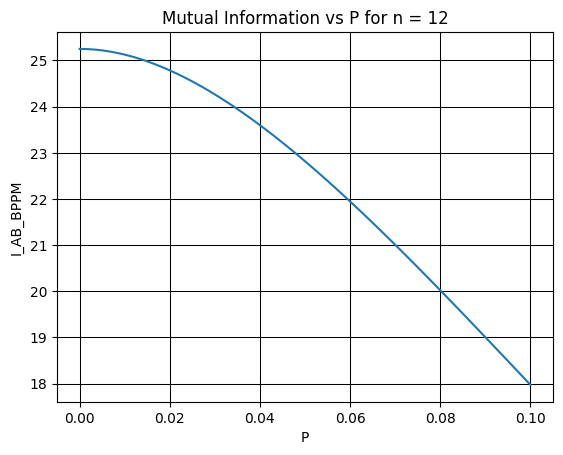

In [125]:
def calculate_I_AB_BPPM_optimized(P, n, P_to_PD, precomputed_values):
    P_D_val = P_to_PD[P]

    diag_elements = precomputed_values[P]['diag_elements']
    H_A_val = precomputed_values[P]['H_A_val']
    H_B_val = precomputed_values[P]['H_B_val']
    H_AB_val = precomputed_values[P]['H_AB_val']
    
    I_AB_val = I_AB(H_A_val, H_B_val, H_AB_val, P_D_val)

    return I_AB_val

# def calculate_I_AB_BPPM_optimized_wrapper(P, n, P_to_PD, precomputed_values):
#     return calculate_I_AB_BPPM_optimized(P, n, P_to_PD, precomputed_values)

# Precompute values for faster calculations later
# Precompute values for faster calculations later
precomputed_values = precompute_values(n, df_P_D.set_index('P')['P_D'].to_dict(), df_matrix_size)

num_workers = 8

with ThreadPoolExecutor(max_workers=num_workers) as executor:
    I_AB_BPPM_list_11 = list(executor.map(lambda P: calculate_I_AB_BPPM_optimized(P, n, df_P_D.set_index('P')['P_D'].to_dict(), precomputed_values), P_list))

# with ProcessPoolExecutor(max_workers=num_workers) as executor:
#     I_AB_BPPM_list_11 = list(executor.map(lambda P: calculate_I_AB_BPPM_optimized_wrapper(P, n, df_P_D.set_index('P')['P_D'].to_dict(), precomputed_values), P_list))

plt.plot(P_list, I_AB_BPPM_list_11)
plt.xlabel('P')
plt.ylabel('I_AB_BPPM')
plt.title('Mutual Information vs P for n = 12')
plt.grid(color='k', linestyle='-', linewidth=0.75)
plt.show()

In [107]:
print(df_matrix_size)

    number  Time Bin            factorial  \
0        1         1                    1   
1        2         3                    2   
2        3         7                    6   
3        4        14                   24   
4        5        26                  120   
5        6        46                  720   
6        7        75                 5040   
7        8       113                40320   
8        9       165               362880   
9       10       238              3628800   
10      11       332             39916800   
11      12       459            479001600   
12      13       610           6227020800   
13      14       791          87178291200   
14      15      1002        1307674368000   
15      16      1259       20922789888000   
16      17      1574      355687428096000   
17      18      1947     6402373705728000   
18      19      2359   121645100408832000   
19      20      2834  2432902008176640000   

                                     size  
0         

In [108]:
print(f"P: {P}, P_D_val: {P_D_val}")


P: 0.1, P_D_val: None


In [62]:
import timeit

# Time the precompute_values function
start_time = timeit.default_timer()
precomputed_values = precompute_values(n, df_P_D.set_index('P')['P_D'].to_dict(), df_matrix_size)
end_time = timeit.default_timer()
print(f"Time taken by precompute_values: {end_time - start_time} seconds")

# Time the ThreadPoolExecutor block
start_time = timeit.default_timer()
with ThreadPoolExecutor(max_workers=num_workers) as executor:
    I_AB_BPPM_list_11 = list(executor.map(lambda P: calculate_I_AB_BPPM_optimized(P, n, df_P_D.set_index('P')['P_D'].to_dict(), precomputed_values), P_list))
end_time = timeit.default_timer()
print(f"Time taken by ThreadPoolExecutor: {end_time - start_time} seconds")


Time taken by precompute_values: 0.0026974170000357844 seconds
Time taken by ThreadPoolExecutor: 0.028892709000047034 seconds


In [ ]:
# def calculate_I_AB_BPPM(P, n, P_to_PD, df_matrix_size):
#     # Extract the corresponding P_D value using the dictionary
#     P_D_val = P_to_PD[P]

#     diag_elements = compute_diag_elements(n, P_D_val, df_matrix_size)

#     H_A_val = H_A(diag_elements)
#     H_B_val = H_B(diag_elements)
#     H_AB_val = H_AB(diag_elements)
#     I_AB_val = I_AB(H_A_val, H_B_val, H_AB_val, P_D_val)

#     return I_AB_val

# num_workers = 8  # Set to the number of CPU cores available on your system

# # Create a dictionary that maps P values to their corresponding P_D values
# P_to_PD = dict(zip(df_P_D['P'], df_P_D['P_D']))

# with ThreadPoolExecutor(max_workers=num_workers) as executor:
#     I_AB_BPPM_list_11 = list(executor.map(lambda P: calculate_I_AB_BPPM(P, n, P_to_PD, df_matrix_size), P_list))


# plt.plot(P_list, I_AB_BPPM_list_11)
# plt.xlabel('P')
# plt.ylabel('I_AB_BPPM')
# plt.title('Mutual Information vs P for n = 12')
# plt.grid(color='k', linestyle='-', linewidth=0.75)
# plt.show()


In [ ]:
# from concurrent.futures import ThreadPoolExecutor

# def calculate_I_AB_BPPM(P, n, df_P_D, df_matrix_size):
#     # Find the row with the desired P value
#     row = df_P_D[df_P_D['P'] == P]

#     # Extract the corresponding P_D value
#     P_D_val = row['P_D'].values[0]

#     diag_elements = compute_diag_elements(n, P_D_val, df_matrix_size)

#     H_A_val = H_A(diag_elements)
#     H_B_val = H_B(diag_elements)
#     H_AB_val = H_AB(diag_elements)
#     I_AB_val = I_AB(H_A_val, H_B_val, H_AB_val, P_D_val)

#     return I_AB_val


# n = 12
# num_workers = 8  # Set to the number of CPU cores available on your system

# with ThreadPoolExecutor(max_workers=num_workers) as executor:
#     I_AB_BPPM_list_11 = list(executor.map(lambda P: calculate_I_AB_BPPM(P, n, df_P_D, df_matrix_size), P_list))


In [ ]:
I_AB_list = []

P_list = np.linspace(1e-6, 0.1, 101)


for P in P_list:
    n = 11
    N_n = compute_N(n)
    P_D_val = P_D(n, P, 0, 0, 0, N_n)

    diag_elements = compute_diag_elements(n, P_D_val)

    H_A_val = H_A(diag_elements)
    H_B_val = H_B(diag_elements)
    H_AB_val = H_AB(diag_elements)
    I_AB_val = I_AB(H_A_val, H_B_val, H_AB_val, P_D_val)
    I_AB_list.append(I_AB_val)

# for P in P_list:
#     n = 11
#     N_n = compute_N(n)
#     P_D_val = P_D(n, P, 0, 0, 0, N_n)

#     P_AB_val = P_AB(n, P_D_val)
#     H_A_val = entropy(P_AB_val.diagonal())
#     H_B_val = entropy(P_AB_val.diagonal())
#     H_AB_val = entropy(P_AB_val.diagonal())
#     I_AB_val = I_AB(H_A_val, H_B_val, H_AB_val, P_D_val)
#     I_AB_list.append(I_AB_val)

    # Rest of the loop


# for P in P_list:
#     n = 10
#     N_n = compute_N(n)
#     P_D_val = P_D(n, P, 0, 0, 0, N_n)

#     P_AB_val = P_AB(n, P_D_val)

#     H_A_val = entropy(P_AB_val.diagonal())
#     H_B_val = entropy(P_AB_val.diagonal())
#     H_AB_val = entropy(P_AB_val.diagonal())
#     I_AB_val = I_AB(H_A_val, H_B_val, H_AB_val, P_D_val)
#     I_AB_list.append(I_AB_val)

plt.plot(P_list, I_AB_list, label='I_AB renormalized', linewidth=3, alpha=1)

plt.xlabel('Probability, P')
plt.ylabel('Mutual Information, I_AB')

plt.grid(color='k', linestyle='-', linewidth=0.75)

plt.legend()

plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import itertools
import math

from pyparsing import python_style_comment
from itertools import islice
import scipy.sparse as sps
from scipy.sparse import diags
from functools import lru_cache
from multiprocessing import Pool
from scipy.special import comb as combination

In [ ]:
comb_cache = {}
#we need combination to calculate Loss_Disitribution, Add_Distribution, P_err
# define a separate function for computing the sequence of terms used in N
# def combination(n, r):
#     # if r > n:
#     #     return 0
#     # else:
#     return math.factorial((int(n))) / (math.factorial((int(n-r))) * math.factorial((int(r))))

# def combination(n, r):
#     if (n, r) in comb_cache:
#         return comb_cache[(n, r)]
#     else:
#         comb = math.factorial(n) // (math.factorial(n-r) * math.factorial(r))
#         comb_cache[(n, r)] = comb
#         return comb

@lru_cache(maxsize=None)
def combination(n, r):
    if r > n:
        return 0
    elif r == 0 or r == n:
        return 1
    else:
        return combination(n-1, r-1) + combination(n-1, r)
    
# @lru_cache(maxsize=None)
# def compute_N(n):
#   def agen(): # generator of terms
#       aset, sset, k = set(), set(), 0
#       while True:
#           k += 1
#           while any(k+an in sset for an in aset): k += 1
#           yield k; sset.update(k+an for an in aset); aset.add(k)
#   a = list(islice(agen(), 100))
#   photon = list(map(lambda v: v-1, a))
#   compute_N= [sum(photon[:i]) for i in range(1,len(photon)+1)]
#   return compute_N[n]

@lru_cache(maxsize=None)
def compute_N(n):
    aset, sset, k = set(), set(), 0
    gen_exp = (k for _ in range(100) if (k := next(i for i in range(k+1, 2*k+2) if i not in {k+an for an in aset})))
    photon = [v-1 for v in islice(gen_exp, 100)]
    compute_N_result = [sum(photon[:i]) for i in range(1, len(photon)+1)]
    return compute_N_result[n]


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy.special import comb as combination
from scipy.sparse import diags
import scipy.sparse as sps

import numpy as np
import matplotlib.pyplot as plt
import math
from scipy.special import comb

comb_n_cache = {}
comb_n_M_minus_n_cache = {}

@lru_cache(maxsize=None)
def compute_N(n):
    aset, sset, k = set(), set(), 0
    gen_exp = (k for _ in range(100) if (k := next(i for i in range(k+1, 2*k+2) if i not in {k+an for an in aset})))
    photon = [v-1 for v in islice(gen_exp, 100)]
    compute_N_result = [sum(photon[:i]) for i in range(1, len(photon)+1)]
    return compute_N_result[n]

# @lru_cache(maxsize=None)
# def combination(n, r):
#     if r > n:
#         return 0
#     elif r == 0 or r == n:
#         return 1
#     else:
#         return combination(n-1, r-1) + combination(n-1, r)
    
# def vectorized_combination(n, r):
#     n, r = np.broadcast_arrays(n, r)
#     result = np.zeros_like(n)
#     mask = (r <= n) & (r >= 0)
#     result[mask] = np.array([math.comb(int(nv), int(rv)) for nv, rv in zip(n[mask], r[mask])])
#     return result

# def vectorized_combination(n, r):
#     n, r = np.broadcast_arrays(n, r)
#     result = np.zeros_like(n)
#     mask = (r <= n) & (r >= 0)
#     result[mask] = np.array([comb(int(nv), int(rv), exact=True) for nv, rv in zip(n[mask], r[mask])])
#     return result

from scipy.special import gammaln

def vectorized_combination(n, r):
    n, r = np.broadcast_arrays(n, r)
    result = np.zeros_like(n, dtype=np.float64)
    mask = (r <= n) & (r >= 0)
    result[mask] = np.exp(gammaln(n[mask] + 1) - gammaln(r[mask] + 1) - gammaln(n[mask] - r[mask] + 1))
    return result


# def Loss_Distribute(n, P_l, l):
#     comb_n = combination(n, l)
#     return comb_n * (P_l)**l * (1 - P_l)**(n - l)

# def Add_Distribute(n, P_a, a, N_n):
#     M_minus_n = N_n - n
#     comb_Nn_Mn = combination(N_n + M_minus_n, a)
#     return comb_Nn_Mn * (P_a)**a * (1 - P_a)**(M_minus_n - a)

# def P_err(n, P_l, P_a, l, a, N_n):
#     return Loss_Distribute(n, P_l, l) * Add_Distribute(n, P_a, a, N_n)

# def P_err(n, P_l, P_a, l, a, N_n):
#     Loss_Distribute = combination(n, l) * (P_l)**l * (1 - P_l)**(n - l)
#     Add_Distribute = combination(N_n + N_n - n, a) * (P_a)**a * (1 - P_a)**(N_n - n - a)
#     return Loss_Distribute * Add_Distribute

def P_err(n, P_l, P_a, l, a, N_n):
    Loss_Distribute = vectorized_combination(n, l) * (P_l)**l * (1 - P_l)**(n - l)
    Add_Distribute = vectorized_combination(N_n + N_n - n, a) * (P_a)**a * (1 - P_a)**(N_n - n - a)
    return Loss_Distribute * Add_Distribute

# def P_Success0(n, P_l, P_a, l, a, N_n):
#     return P_err(n, P_l, P_a, 0, 0, N_n)

# def P_Success1(n, P_l, P_a, l, a, N_n):
#     P0 = P_Success0(n, P_l, P_a, l, a, N_n)
#     P1 = P_err(n, P_l, P_a, 0, 1, N_n) + P_err(n, P_l, P_a, 1, 0, N_n)
#     return P0 + P1

# def P_D(n, P_l, P_a, l, a, N_n):
#     return 1 - P_Success1(n, P_l, P_a, l, a, N_n)

# def P_D(n, P_l, P_a, l, a, N_n): # for at most 1 error 
#     return 1 - (P_err(n, P_l, P_a, 0, 0, N_n) + P_err(n, P_l, P_a, 0, 1, N_n) + P_err(n, P_l, P_a, 1, 0, N_n))

def P_D(pd, n, l, a, N_n):
    N_A = N_n[:, a]
    N_l = N_A[l]
    return N_l * (1 - pd) / n


# def I_AB(H_A, H_B, H_AB, P_D):
#     if np.isnan(H_AB):
#         return 0
#     else:
#         return ((H_A + H_B - H_AB))*(1-P_D)

def I_AB(H_A, H_B, H_AB, P_D):
    return np.where(np.isnan(H_AB), 0, H_A + H_B - H_AB)


# def P_AB(n, P_D):
#     factorial_n = round(math.gamma(n + 1))
#     diag_data = (1 / factorial_n) * (1 - P_D) * np.ones(factorial_n)
#     matrix = sps.dia_matrix((diag_data, 0), shape=(factorial_n, factorial_n))
#     return matrix

def P_AB(n, P_D):
    factorial_n = round(math.gamma(n + 1))
    diag_data = (1 / factorial_n) * (1 - P_D) * np.ones(factorial_n)
    matrix = np.diag(diag_data)
    return matrix


# def P_AB(n, P_D):
#     factorial_n = round(math.gamma(n + 1))
#     diag_data = (1 / factorial_n) * (1 - P_D) * np.ones((P_D.shape[0], factorial_n))
#     matrix = sps.dia_matrix((diag_data, np.zeros(P_D.shape[0])), shape=(P_D.shape[0], factorial_n, factorial_n))
#     return matrix

# def P_AB(n, P_D):
#     factorial_n = round(math.gamma(n + 1))
#     diag_data = (1 / factorial_n) * (1 - P_D) * np.ones((P_D.shape[0], factorial_n))
#     matrix = sps.dia_matrix((diag_data, np.zeros(diag_data.shape[1])), shape=(diag_data.shape[0], diag_data.shape[1], diag_data.shape[1]))
#     return matrix

# def P_AB(n, P_D):
#     factorial_n = round(math.gamma(n + 1))
#     diag_data = (1 / factorial_n) * (1 - P_D) * np.ones((P_D.shape[0], factorial_n))
#     matrix = sps.dia_matrix((diag_data, [0]), shape=(diag_data.shape[0], diag_data.shape[1]))
# #     return matrix

# def P_AB(n, P_D):
#     P_D = np.asarray(P_D)
#     factorial_n = round(math.gamma(n + 1))
#     diag_data = (1 / factorial_n) * (1 - P_D) * np.ones((P_D.shape[0], factorial_n))
#     offsets = np.zeros((1,), dtype=int)
#     matrix = sps.dia_matrix((diag_data, offsets), shape=(diag_data.shape[0], diag_data.shape[1]))
#     return matrix.toarray()

# def P_AB(n, P_D):
#     P_D = np.asarray(P_D)
#     factorial_n = round(math.gamma(n + 1))
#     diag_data = np.array([(1 / factorial_n) * (1 - p) * np.ones(factorial_n) for p in P_D])
#     offsets = np.zeros((1,), dtype=int)
#     matrices = [sps.dia_matrix((data, offsets), shape=(factorial_n, factorial_n)).toarray() for data in diag_data]
#     return np.stack(matrices)

def entropy(P):
    P_non_zero = np.where(P == 0, 1, P)
    H = -np.sum(P * np.log2(P_non_zero))
    return H

def H_A(P_AB):
    P_A = P_AB.diagonal()
    return -np.sum(P_A * np.log2(np.where(P_A == 0, 1, P_A)))

def H_B(P_AB):
    P_B = P_AB.diagonal()
    return -np.sum(P_B * np.log2(np.where(P_B == 0, 1, P_B)))

# def H_AB(P_AB):
#     P_AB = P_AB.diagonal()
#     P_AB = np.where(P_AB == 0, 1e-9, P_AB)  # replace zero values with 1e-9
#     return -(P_AB * np.log2(P_AB)).sum()

def H_AB(P_AB):
    P_AB_non_zero = np.where(P_AB == 0, 1, P_AB)
    H = -np.sum(P_AB * np.log2(P_AB_non_zero))
    return H


# Rest of the code remains the same


# def compute_mutual_information(P_list, n, N_n):
#     P_l = P_list[:, np.newaxis, np.newaxis, np.newaxis, np.newaxis]
#     P_a = np.zeros_like(P_l)
#     l, a = np.meshgrid(np.arange(n + 1), np.arange(N_n - n + 1), indexing='ij')

#     P_err_val = P_err(n, P_l, P_a, l, a, N_n)
#     P_D_val = P_D(n, P_l, P_a, l, a, N_n)

#     P_AB_val = P_AB(n, P_D_val)
#     H_A_val = entropy(P_AB_val.diagonal())
#     H_B_val = entropy(P_AB_val.diagonal())
#     H_AB_val = entropy(P_AB_val.diagonal())
#     I_AB_val = I_AB(H_A_val, H_B_val, H_AB_val, P_D_val)

#     return I_AB_val

# def compute_mutual_information(P_list, n, N_n):
#     P_l = P_list[:, np.newaxis, np.newaxis]
#     P_a = np.zeros_like(P_l)
#     l, a = np.meshgrid(np.arange(n + 1), np.arange(N_n - n + 1), indexing='ij')
    
#     P_err_val = P_err(n, P_l, P_a, l, a, N_n)
#     P_D_val = P_D(n, P_l, P_a, l, a, N_n)

#     P_AB_val = P_AB(n, P_D_val)
#     H_A_val = entropy(P_AB_val.diagonal())
#     H_B_val = entropy(P_AB_val.diagonal())
#     H_AB_val = entropy(P_AB_val.diagonal())
#     I_AB_val = I_AB(H_A_val, H_B_val, H_AB_val, P_D_val)

# def compute_mutual_information(P_list, n, N_n):
#     P_l = P_list[:, np.newaxis, np.newaxis]
#     P_a = np.zeros_like(P_l)
#     l, a = np.meshgrid(np.arange(n + 1), np.arange(N_n - n + 1), indexing='ij')
    
#     P_err_val = P_err(n, P_l, P_a, l, a, N_n)
#     P_D_val = P_D(n, P_l, P_a, l, a, N_n)

#     P_AB_val = np.array([P_AB(n, pd) for pd in P_D_val])
#     # H_A_val = np.array([entropy(pab.diagonal()) for pab in P_AB_val])
#     # H_B_val = np.array([entropy(pab.diagonal()) for pab in P_AB_val])
#     # H_A_val = np.array([entropy(np.diagonal(pab)) for pab in P_AB_val])
#     # H_B_val = np.array([entropy(np.diagonal(pab)) for pab in P_AB_val])
#     H_A_val = np.array([entropy(np.diagonal(pab)) if pab.ndim >= 2 else entropy(pab) for pab in P_AB_val])
#     H_B_val = np.array([entropy(np.diagonal(pab)) if pab.ndim >= 2 else entropy(pab) for pab in P_AB_val])

#     # H_AB_val = np.array([entropy(pab) for pab in P_AB_val])  # modified this line
#     H_AB_val = np.array([-np.sum(pab * np.where(pab != 0, np.log2(pab), 0)) for pab in P_AB_val])

#     I_AB_val = I_AB(H_A_val, H_B_val, H_AB_val, P_D_val)

#     return I_AB_val

def compute_mutual_information(P_list, n, l, a, N_n):
    P_D_val = np.array([P_D(pd, n, l, a, N_n) for pd in P_list])
    P_AB_val = np.array([P_AB(n, pd) for pd in P_D_val])
    H_A_val = np.array([entropy(np.diagonal(pab)) if pab.ndim >= 2 else entropy(pab) for pab in P_AB_val])
    H_AB_val = np.array([entropy(pab) for pab in P_AB_val])
    I_AB = H_A_val + H_A_val - H_AB_val
    return I_AB




#     return I_AB_val

# I_AB_list = []

P_list = np.linspace(1e-6, 0.1, 101)

n = 9

N_n = compute_N(n)

# I_AB_val = compute_mutual_information(P_list, n, N_n)
# I_AB_list = I_AB_val.reshape(-1).tolist()

# for P in P_list:
#     n = 12
#     N_n = compute_N(n)
#     P_D_val = P_D(n, P, 0, 0, 0, N_n)

#     P_AB_val = P_AB(n, P_D_val)

#     # H_A_val = H_A(P_AB_val)
#     # H_B_val = H_B(P_AB_val)
#     # H_AB_val = H_AB(P_AB_val)
#     # I_AB_val = I_AB(H_A_val, H_B_val, H_AB_val, P_D_val)
#     # I_AB_list.append(I_AB_val)
#     H_A_val = entropy(P_AB_val.diagonal())
#     H_B_val = entropy(P_AB_val.diagonal())
#     H_AB_val = entropy(P_AB_val.diagonal())
#     I_AB_val = I_AB(H_A_val, H_B_val, H_AB_val, P_D_val)
#     I_AB_list.append(I_AB_val)

l= 0
a= 0
I_AB_list = compute_mutual_information(P_list, n, l, a, N_n)


plt.plot(P_list, I_AB_list, label='I_AB renormalized', linewidth=3, alpha=1)

plt.xlabel('Probability, P')
plt.ylabel('Mutual Information, I_AB')

plt.grid(color='k', linestyle='-', linewidth=0.75)

plt.legend()

plt.show()


In [ ]:
print("H_A_val:", H_A_val)
print("H_B_val:", H_B_val)
print("H_AB_val:", H_AB_val)

In [ ]:
I_AB_list = compute_mutual_information(P_list, n, N_n)

plt.plot(P_list, I_AB_list)
plt.xlabel("P_l")
plt.ylabel("I_AB")
plt.title("I_AB vs P_l")
plt.grid(True)
plt.show()

In [ ]:
P_AB(5, P_D(5, 0, 0, 0, 0, compute_N(5))).shape

In [ ]:
I_AB_list = []

P_list = np.linspace(1e-6,0.1,101)

for P in P_list:
    n = 11
    N_n = compute_N(n)
    P_D_val = P_D(n, P, 0, 0, 0, N_n)

    P_AB_val = P_AB(n, P_D_val)

    H_A_val = H_A(P_AB_val)
    H_B_val = H_B(P_AB_val)
    H_AB_val = H_AB(P_AB_val)
    I_AB_val = I_AB(H_A_val, H_B_val, H_AB_val, P_D_val)
    I_AB_list.append

# Normalized

In [ ]:
def P_AB(n, P, P_D):
    factorial_n = math.factorial(n)
    diag_data = (1/factorial_n) * (1-P_D) * np.ones(factorial_n)
    matrix = sps.dia_matrix((diag_data, 0), shape=(factorial_n, factorial_n))
    return matrix

def H_A(P_AB):
    P_A = P_AB.diagonal()
    H_a = np.sum(-P_A * np.log2(np.where(P_A == 0, 1, P_A)))
    return H_a

def H_B(P_AB):
    P_B = P_AB.diagonal()
    H_b = np.sum(-P_B * np.log2(np.where(P_B == 0, 1, P_B)))
    return H_b

def H_AB(P_AB):
    P_AB = P_AB.diagonal()
    P_AB = np.where(P_AB == 0, 1e-9, P_AB)  # replace zero values with 1e-9
    H = -(P_AB * np.log2(P_AB)).sum()
    return H

I_AB_list = []

P_list = np.linspace(1e-6,0.1,101)

for P in P_list:
  n = 11
  N_n = compute_N(n) 
  P_D_val = P_D(n,P, 0,0,0)
  
  P_AB_val = P_AB(n, P, P_D_val)
  
  H_A_val = H_A(P_AB_val)
  H_B_val = H_B(P_AB_val)
  H_AB_val = H_AB(P_AB_val)
  I_AB_val = I_AB(H_A_val, H_B_val, H_AB_val, P_D_val)
  I_AB_normalized_val = I_AB(H_A_val, H_B_val, H_AB_val, P_D_val) / I_AB(H_A_val, H_B_val, H_AB_val, 0)
  I_AB_list.append(I_AB_normalized_val)


In [ ]:
plt.plot(P_list, I_AB_list, label='I_AB_BPPM renormalized', linewidth=3, alpha=1)

# Add axis labels and a title
plt.xlabel('Probability, P')
plt.ylabel('Muutal Information, I_AB')
plt.title('Mutual Information of BPPM (n = 5), PPM (M = 5) and  \n General Protocol (n =2, 3) vs. Probability 0 \u2264 P \u2264 0.1', fontsize='x-large')

plt.grid(color='k', linestyle='-', linewidth=0.75)

# Add a legend
plt.legend()

# Show the plot
plt.show()

Now it takes more than a minute to run the iteration for n = 11.

Since we only use the diagonal elements of the matrix, we don't need to compute the entire matrix. 

Instead, we can calculate only the diagonal elements directly and avoid creating the matrix altogether. This will save both memory and computation time.

In [ ]:
def compute_M(M):
  return M

In [ ]:
def Compute_G_n(n_General):
    return n_General

def compute_T_General(n_General, M):
  T_General = compute_M(M) * n_General
  return T_General

#we need combination to calculate Loss_Disitribution, Add_Distribution, P_err
# define a separate function for computing the sequence of terms used in N
def combination_General(T_General, n_General):
    # if r > n:
    #     return 0
    # else:
    # return math.factorial((int(T_General))) / (math.factorial((int(T_General-n_General))) * math.factorial((int(n_General))))
    return math.factorial(((T_General))) / (math.factorial(((T_General-n_General))) * math.factorial(((n_General))))

# We need LossDisitribution, AddDistribution, Perr to calculate PSuccess0, PSuccess1, PSuccess2 and so on
# define a separate function for computing the loss distribution

def Loss_Distribute_General(n_General, P_l, l):
    # if P_l == 0:
    #     return 1
    # else:
      return combination(n_General, l) * (P_l)**l * (1 - P_l)**(n_General - l)

def Add_Distribute_General(n_General, P_a, a):
    
    T_General = compute_T_General(n_General)
    # if P_a == 0:
    #     return 1
    # else:
    return combination(T_General - n_General, a) * (P_a)**a * (1 - P_a)**(T_General - n_General - a)

# define a separate function for computing the probability of error
def P_err(n_General, P_l, P_a,l,a):
  return Loss_Distribute(n_General,P_l,l) * Add_Distribute(n_General,P_a, a)

def P_Success_General(n_General,P_l,P_a,l,a):
  return P_err(n_General,P_l, P_a, l=0, a=0) 

# Perr[l = 0, a = 0, n = 1, N = M, Ploss, Padd] from mathematica

def P_D_General(n_General,P_l,P_a, l=0,a=0):
  return 1 - P_Success_General(n_General,P_l,P_a, l=0, a=0)

def P_A_General(P_AB_General, P_D_General):
    if P_D == 1:
        return [1 for row in P_AB_General]
    else:
        return [sum(row) for row in P_AB_General] # 1/(1-P_D_OOK)*

# sum over the elements in columns in the probability matrix P_AB
def P_B_General(P_AB_General, P_D_General):
    if P_D == 1:
        return [1 for col in zip(*P_AB_General)]
    else:
        return [sum(col) for col in zip(*P_AB_General)]

def I_AB_General(H_A_General, H_B_General, H_AB_General, P_D_General):
    if np.isnan(H_AB_General):
        return 0
    else:
        return ((H_A_General + H_B_General - H_AB_General)) * (1-P_D_General)

In [ ]:
def P_AB_diag_General(M, n_General):
    T_General = compute_T_General(n_General, M)
    diag_data = np.ones(int(combination(T_General, n_General))) / combination(T_General, n_General)
    matrix = sps.dia_matrix((diag_data, 0), shape=(diag_data.size, diag_data.size))
    return matrix
    
def H_A_General(P_A_General):
    P_A_General_diag = P_A_General.diagonal()
    H_a_General = np.sum(-P_A_General_diag * np.log2(np.where(P_A_General_diag == 0, 1, P_A_General_diag)))
    return H_a_General

def H_B_General(P_B_General):
    P_B_General_diag = P_B_General.diagonal()
    H_b_General = np.sum(-P_B_General_diag * np.log2(np.where(P_B_General_diag == 0, 1, P_B_General_diag)))
    return H_b_General

def H_AB_General(P_AB_General):
    P_AB_General_diag = P_AB_General.diagonal()
    P_AB_General_diag = np.where(P_AB_General_diag == 0, 1e-9, P_AB_General_diag)  # replace zero values with 1e-9
    H_General = -(P_AB_General_diag * np.log2(P_AB_General_diag)).sum()
    return H_General


In [ ]:
I_AB_General_n2_list_10 = []
I_AB_General_n3_list_10 = []

P_list = np.linspace(1e-6,0.1,101)

for P in P_list:
  M = 5
  compute_M(M)
  n_General = Compute_G_n(2)
  T_General = compute_T_General(n_General, M)

  P_D_General_val = P_D_General(n_General, P, 0, l=0, a=0)

  P_AB_General_diag_val = P_AB_diag_General(M, n_General)
  P_AB_General_diag_val = P_AB_General_diag_val.todia()
  P_AB_General_diag_val.setdiag(np.where(P_AB_General_diag_val.diagonal() <= 0, 1e-9, P_AB_General_diag_val.diagonal()))
  H_A_General_val = H_A_General(P_AB_General_diag_val)
  H_B_General_val = H_B_General(P_AB_General_diag_val)
  H_AB_General_val = H_AB_General(P_AB_General_diag_val)
  I_AB_General_val = I_AB_General(H_A_General_val, H_B_General_val, H_AB_General_val, P_D_General_val)
  
  I_AB_General_n2_normalized_val =  I_AB_General(H_A_General_val, H_B_General_val, H_AB_General_val, P_D_General_val) / I_AB_General(H_A_General_val, H_B_General_val, H_AB_General_val, 0)
  I_AB_General_n2_list_10.append(I_AB_General_n2_normalized_val)

  n_General = Compute_G_n(3)
  T_General = compute_T_General(n_General, M)

  P_D_General_val = P_D_General(n_General, P, 0, l=0, a=0)

  P_AB_General_diag_val = P_AB_diag_General(M, n_General)
  P_AB_General_diag_val = P_AB_General_diag_val.todia()
  P_AB_General_diag_val.setdiag(np.where(P_AB_General_diag_val.diagonal() <= 0, 1e-9, P_AB_General_diag_val.diagonal()))

  H_A_General_val = H_A_General(P_AB_General_diag_val)
  H_B_General_val = H_B_General(P_AB_General_diag_val)
  H_AB_General_val = H_AB_General(P_AB_General_diag_val)
  I_AB_General_val = I_AB_General(H_A_General_val, H_B_General_val, H_AB_General_val, P_D_General_val)
  
  I_AB_General_n3_normalized_val = I_AB_General(H_A_General_val, H_B_General_val, H_AB_General_val, P_D_General_val) / I_AB_General(H_A_General_val, H_B_General_val, H_AB_General_val, 0)
  I_AB_General_n3_list_10.append(I_AB_General_n3_normalized_val)

In [ ]:
def P_AB_diag(n, P, P_D):
    factorial_n = math.factorial(n)
    diag_data = (1/factorial_n) * (1-P_D) * np.ones(factorial_n)
    return diag_data


In [ ]:
def H_A(P_A):
    H_a = np.sum(-P_A * np.log2(np.where(P_A == 0, 1, P_A)))
    return H_a

def H_B(P_B):
    H_b = np.sum(-P_B * np.log2(np.where(P_B == 0, 1, P_B)))
    return H_b

def H_AB(P_AB):
    P_AB = np.where(P_AB == 0, 1e-9, P_AB)  # replace zero values with 1e-9
    H = -(P_AB * np.log2(P_AB)).sum()
    return H


In [ ]:
# I_AB_list = []

# P_list = np.linspace(1e-6, 0.999999, 101)

# for P in P_list:
#     n = 12
#     N_n = compute_N(n) 
#     P_D_val = P_D(n, P, 0, 0, 0)

#     P_AB_diag_val = P_AB_diag(n, P, P_D_val)

#     H_A_val = H_A(P_AB_diag_val)
#     H_B_val = H_B(P_AB_diag_val)
#     H_AB_val = H_AB(P_AB_diag_val)
#     I_AB_val = I_AB(H_A_val, H_B_val, H_AB_val, P_D_val)
#     I_AB_list.append(I_AB_val)


Still, it can not run faster as expected

In [ ]:
P_AB(5, 0, P_D(5,0, 0,0,0)) *(120) * (1/1-P_D(5,0, 0,0,0))

# General Protocol

In [ ]:
def compute_M(M):
  return M

In [ ]:
def Compute_G_n(n_General):
    return n_General

def compute_T_General(n_General, M):
  T_General = compute_M(M) * n_General
  return T_General

#we need combination to calculate Loss_Disitribution, Add_Distribution, P_err
# define a separate function for computing the sequence of terms used in N
def combination_General(T_General, n_General):
    # if r > n:
    #     return 0
    # else:
    # return math.factorial((int(T_General))) / (math.factorial((int(T_General-n_General))) * math.factorial((int(n_General))))
    return math.factorial(((T_General))) / (math.factorial(((T_General-n_General))) * math.factorial(((n_General))))

# We need LossDisitribution, AddDistribution, Perr to calculate PSuccess0, PSuccess1, PSuccess2 and so on
# define a separate function for computing the loss distribution

def Loss_Distribute_General(n_General, P_l, l):
    # if P_l == 0:
    #     return 1
    # else:
      return combination(n_General, l) * (P_l)**l * (1 - P_l)**(n_General - l)

def Add_Distribute_General(n_General, P_a, a):
    
    T_General = compute_T_General(n_General)
    # if P_a == 0:
    #     return 1
    # else:
    return combination(T_General - n_General, a) * (P_a)**a * (1 - P_a)**(T_General - n_General - a)

# define a separate function for computing the probability of error
def P_err(n_General, P_l, P_a,l,a):
  return Loss_Distribute(n_General,P_l,l) * Add_Distribute(n_General,P_a, a)

def P_Success_General(n_General,P_l,P_a,l,a):
  return P_err(n_General,P_l, P_a, l=0, a=0) 

# Perr[l = 0, a = 0, n = 1, N = M, Ploss, Padd] from mathematica

def P_D_General(n_General,P_l,P_a, l=0,a=0):
  return 1 - P_Success_General(n_General,P_l,P_a, l=0, a=0)

def P_A_General(P_AB_General, P_D_General):
    if P_D == 1:
        return [1 for row in P_AB_General]
    else:
        return [sum(row) for row in P_AB_General] # 1/(1-P_D_OOK)*

# sum over the elements in columns in the probability matrix P_AB
def P_B_General(P_AB_General, P_D_General):
    if P_D == 1:
        return [1 for col in zip(*P_AB_General)]
    else:
        return [sum(col) for col in zip(*P_AB_General)]

def I_AB_General(H_A_General, H_B_General, H_AB_General, P_D_General):
    if np.isnan(H_AB_General):
        return 0
    else:
        return ((H_A_General + H_B_General - H_AB_General)) * (1-P_D_General)


In [ ]:
def P_AB_diag_General(M, n_General):
    T_General = compute_T_General(n_General, M)
    diag_data = np.ones(int(combination(T_General, n_General))) / combination(T_General, n_General)
    return diag_data


def H_A_General(P_A_General):
    H_a_General = np.sum(-P_A_General * np.log2(np.where(P_A_General == 0, 1, P_A_General)))
    return H_a_General

def H_B_General(P_B_General):
    H_b_General = np.sum(-P_B_General * np.log2(np.where(P_B_General == 0, 1, P_B_General)))
    return H_b_General

def H_AB_General(P_AB_General):
    P_AB_General = np.where(P_AB_General == 0, 1e-9, P_AB_General)  # replace zero values with 1e-9
    H_General = -(P_AB_General * np.log2(P_AB_General)).sum()
    return H_General



I_AB_General_n2_list_00 = []
I_AB_General_n3_list_00 = []

P_list = np.linspace(1e-6, 0.1, 101)

for P in P_list:
    M = 11
    compute_M(M)
    # n_General = 2
    n_General = Compute_G_n(2)
    T_General = compute_T_General(n_General, M)

    P_D_General_val = P_D_General(n_General, P, 0, l=0, a=0)

    P_AB_General_diag_val = P_AB_diag_General(M, n_General)
    P_AB_General_diag_val = np.where(P_AB_General_diag_val <= 0, 1e-9, P_AB_General_diag_val)

    H_A_General_val = H_A_General(P_AB_General_diag_val)
    H_B_General_val = H_B_General(P_AB_General_diag_val)
    H_AB_General_val = H_AB_General(P_AB_General_diag_val)

    I_AB_General_val = I_AB_General(H_A_General_val, H_B_General_val, H_AB_General_val, P_D_General_val)
    I_AB_General_n2_list_00.append(I_AB_General_val)

    n_General = Compute_G_n(3)
    T_General = compute_T_General(n_General, M)

    P_D_General_val = P_D_General(n_General, P, 0, l=0, a=0)

    P_AB_General_diag_val = P_AB_diag_General(M, n_General)
    P_AB_General_diag_val = np.where(P_AB_General_diag_val <= 0, 1e-9, P_AB_General_diag_val)

    H_A_General_val = H_A_General(P_AB_General_diag_val)
    H_B_General_val = H_B_General(P_AB_General_diag_val)
    H_AB_General_val = H_AB_General(P_AB_General_diag_val)

    I_AB_General_val = I_AB_General(H_A_General_val, H_B_General_val, H_AB_General_val, P_D_General_val)
    I_AB_General_n3_list_00.append(I_AB_General_val)
   


In [ ]:
plt.plot(P_list, I_AB_General_n2_list_00, linewidth=3, label='I_AB_General for 2 Photons')
plt.plot(P_list, I_AB_General_n3_list_00, linewidth=3, label='I_AB_General for 3 Photons')
plt.xlabel('Probability, P')
plt.ylabel('Muutal Information, I_AB')
plt.title('Mutual Information of BPPM (n=7), PPM (M =11) and \n General Protocol (n=2,3) vs. Probability 0 \u2264 P \u2264  0.1', fontsize='x-large')

plt.grid(color='k', linestyle='-', linewidth=0.75)

# Add a legend
plt.legend()

# Show the plot
plt.show()

In [ ]:
# def P_AB_BPPM(n, P, P_D):
#     factorial_n = math.factorial(n)
#     matrix = (1/factorial_n) * (1-P_D) * np.diag([1], factorial_n)
#     return matrix

# def P_AB_BPPM(n, P, P_D):
#     factorial_n = math.factorial(n)
#     matrix = (1/factorial_n) * (1-P_D) * np.eye(factorial_n)
#     return matrix

# def P_AB_BPPM(n, P, P_D):
#      factorial_n = math.factorial(n)
#      diagonal = np.full(factorial_n, factorial_n)
#      matrix = np.diag(diagonal) * 1/ (factorial_n) * (1-P_D)
#      return matrix

# def P_AB_BPPM(n, P, P_D):|
#     factorial_n = math.factorial(n)
#     matrix = (1/factorial_n) * (1-P_D) * diags([1] * factorial_n) 
#     return matrix

# sum over the elements in rows in the probability matrix P_AB
# renormalized in P_AB already

# H_A, H_B, H_AB are the same as the trivial case




# def H_A_BPPM(P_AB_BPPM):
#      P_A_BPPM = np.sum(P_AB_BPPM, axis=1)
#      H_a = np.sum(-P_A_BPPM * np.log2(np.where(P_A_BPPM == 0, 1, P_A_BPPM)))
#      return H_a

# def H_B_BPPM(P_AB_BPPM):
#      P_B_BPPM = np.sum(P_AB_BPPM, axis=0)
#      H_b = np.sum(-P_B_BPPM * np.log2(np.where(P_B_BPPM == 0, 1, P_B_BPPM)))
#      return H_b

# def H_AB_BPPM(P_AB_BPPM):
#     P_AB_BPPM = np.where(P_AB_BPPM == 0, 1e-9, P_AB_BPPM)  # replace zero values with 1e-9
#     H = -(P_AB_BPPM * np.log2(P_AB_BPPM)).sum()
#     return H

In [ ]:
np.eye(factorial_n).shape

In [ ]:
P_AB_BPPM_val

In [ ]:
I_AB_BPPM_list = []
P_D_list = []
P_list = np.linspace(1e-6,0.999999,101)

for P in P_list:
  n = 5
  P_D_val = P_D(n,P, 0,0,0)
  P_D_list.append(P_D_val)
  # P_AB_BPPM_val = P_AB_BPPM(n, P, P_D_val)
  #P_AB_BPPM_val = np.eye(factorial_n) * P_AB_BPPM_val 
  # P_AB_BPPM_val = np.array(P_AB_BPPM_val) # convert list of lists to numpy array
  # P_AB_BPPM_val = np.where(P_AB_BPPM_val <= 0, 1e-15, P_AB_BPPM_val)
  # P_AB_BPPM_val = P_AB_BPPM(8, 0, P_D(8,0, 0,0,0))
  # H_A_val = H_A_BPPM(P_AB_BPPM_val)
  # H_B_val = H_B_BPPM(P_AB_BPPM_val)
  # H_AB_val = H_AB_BPPM(P_AB_BPPM_val)
  # I_AB_val = I_AB_BPPM(H_A_BPPM_val, H_B_BPPM_val, H_AB_BPPM_val, P_D_val)
  # I_AB_list.append(I_AB_val)



In [ ]:
P_D_list

In [ ]:
n = 8
factorial_n = math.factorial(n)
diagonal = np.full(factorial_n, factorial_n)
diagonal

In [ ]:
math.factorial(8)

In [ ]:
H_A_BPPM(P_AB_BPPM(5, 0, P_D(n,0, 0,0,0))),H_A_BPPM(P_AB_BPPM(5, 0, P_D(n,0, 0,0,0))).shape 

In [ ]:
P_AB_BPPM(5, 0, P_D(5,0, 0,0,0)).shape

In [ ]:
from scipy.sparse import diags, csr_matrix

# def P_AB_BPPM_sparse(n, P, P_D):
#     factorial_n = math.factorial(n)
#     data = (1/factorial_n) * (1-P_D) * np.ones(factorial_n)
#     offsets = 0
#     matrix = diags(data, offsets)
#     return matrix

# def P_AB_BPPM_sparse(n, P, P_D):
#     factorial_n = math.factorial(n)
#     matrix = (1/factorial_n) * (1-P_D) * diags([1] * factorial_n)
#     return csr_matrix(matrix)

# def P_AB_BPPM_sparse_diagonal(n, P, P_D):
#     P_AB_BPPM = P_AB_BPPM_sparse(n, P, P_D)
#     return P_AB_BPPM.diagonal()

def P_AB_BPPM_sparse_diagonal(n, P, P_D):
    P_AB_BPPM = P_AB_BPPM_sparse(n, P, P_D)
    return P_AB_BPPM.diagonal().flatten()

def P_AB_BPPM_sparse(n, P, P_D):
    factorial_n = math.factorial(n)
    data = (1/factorial_n) * (1-P_D) * np.ones(factorial_n)
    offsets = 0
    matrix = diags(data, offsets)
    return matrix

# using taylor method
# it deos not with the general method
#The only element I want to work out is the diagonal element, and all the off diagonal elements are zero

def P_AB_BPPM(n, P, P_D):
    factorial_n = math.factorial(n)
    matrix = (1/factorial_n) * (1-P_D) * diags([1] * factorial_n) 
    return matrix

def H_A_BPPM(P_AB_BPPM):
    P_A_BPPM = np.sum(P_AB_BPPM, axis=1)
    H_a = np.sum(-P_A_BPPM.reshape(-1, 1) * np.log2(np.where(P_A_BPPM.reshape(-1, 1) == 0, 1e-9, P_A_BPPM.reshape(-1, 1))))
    return H_a

def H_B_BPPM(P_AB_BPPM):
    P_B_BPPM = np.sum(P_AB_BPPM, axis=0)
    H_b = np.sum(-P_B_BPPM.reshape(-1,1) * np.log2(np.where(P_B_BPPM == 0, 1, P_B_BPPM).reshape(-1,1)))
    return H_b

def H_AB_BPPM(P_AB_BPPM):
    P_AB_BPPM = np.where(P_AB_BPPM == 0, 1e-9, P_AB_BPPM)  # replace zero values with 1e-9
    H = -(P_AB_BPPM * np.log2(P_AB_BPPM)).sum()
    return H

In [ ]:
I_AB_BPPM_list = []

P_list = np.linspace(1e-6,0.999999,101)

for P in P_list:
  n = 5
  factorial_n = math.factorial(n)
  N_n = compute_N(n) 
  P_D_val = P_D(n,P, 0,0,0) # P_D(n,P_l,P_a, l=0,a=0)
  P_AB_BPPM_diagonal = P_AB_BPPM_sparse_diagonal(n, P, P_D_val)
  P_AB_BPPM_diagonal = np.where(P_AB_BPPM_diagonal <= 0, 1e-15, P_AB_BPPM_diagonal)
  P_A_BPPM = np.sum(P_AB_BPPM_diagonal[:, np.newaxis], axis=0)
  P_AB_BPPM_val = diags(P_AB_BPPM_diagonal.reshape(-1))

  # P_AB_BPPM_diagonal = P_AB_BPPM_sparse_diagonal(n, P, P_D_val)
  # P_AB_BPPM_diagonal = np.where(P_AB_BPPM_diagonal <= 0, 1e-15, P_AB_BPPM_diagonal)
  # # P_AB_BPPM_val = csr_matrix(diags(P_AB_BPPM_diagonal.reshape(-1, 1)))
  # P_AB_BPPM_val = csr_matrix(diags([P_AB_BPPM_diagonal]))

  H_A_BPPM_val = H_A_BPPM(P_AB_BPPM_diagonal)# .reshape(factorial_n, 1))
  H_B_BPPM_val = H_B_BPPM(P_AB_BPPM_diagonal) # .reshape(factorial_n, 1))
  H_AB_BPPM_val = H_AB_BPPM(P_AB_BPPM_diagonal)# .reshape(factorial_n, 1))
  I_AB_BPPM_val = I_AB_BPPM(H_A_BPPM_val, H_B_BPPM_val, H_AB_BPPM_val, P_D_val)
  I_AB_BPPM_list.append(I_AB_BPPM_val)

In [ ]:
# P_AB_BPPM_diagonal(5, 0, P_D(n,0, 0,0,0)), P_AB_BPPM(5, 0, P_D(n,0, 0,0,0)).shape

In [ ]:
P_AB_BPPM_sparse_diagonal(n, 0, P_D(n,0, 0,0,0)).reshape(factorial_n, 1),  P_AB_BPPM_sparse_diagonal(n, P, P_D_val).reshape(factorial_n, 1).shape

In [ ]:
H_A_BPPM(P_AB_BPPM(5, 0, P_D(n,0, 0,0,0))),H_A_BPPM(P_AB_BPPM(5, 0, P_D(n,0, 0,0,0))).shape

In [ ]:
plt.plot(P_list, I_AB_BPPM_list, label='I_AB_BPPM renormalized', linewidth=3, alpha=1)


# Add axis labels and a title
plt.xlabel('Probability, P')
plt.ylabel('Muutal Information, I_AB')
plt.title('Mutual Information of BPPM (n = 5), PPM (M = 5) and  \n General Protocol (n =2, 3) vs. Probability 0 \u2264 P \u2264 0.1', fontsize='x-large')

plt.grid(color='k', linestyle='-', linewidth=0.75)

# Add a legend
plt.legend()

# Show the plot
plt.show()

Hello everyone, I have a matrix as following matrix, it will be getting larger and larger for a large number of n.
Actually, it is a diagonal matrix, what I want is only to compute the diagonal elements and the off diagonal elements are all zero. Is there any method I can make it work? I am not sure should I use sparse matrix representation instead of a dense matrix. Although this can significantly reduce memory usage and computational time for larger values of n, but I cannot reshape it back to the square matrix form as n! x n!

I hope someone can shed some light! 

```py
def P_AB(n, P, P_D):
    factorial_n = math.factorial(n)
    matrix = (1/factorial_n) * (1-P_D) * np.eye(factorial_n)
    return matrix

def H_A(P_AB):
     P_A = np.sum(P_AB, axis=1)
     H_a = np.sum(-P_A * np.log2(np.where(P_A == 0, 1, P_A)))
     return H_a

def H_B(P_AB):
     P_B = np.sum(P_AB, axis=0)
     H_b = np.sum(-P_B * np.log2(np.where(P_B == 0, 1, P_B)))
     return H_b

def H_AB(P_AB):
    P_AB = np.where(P_AB == 0, 1e-9, P_AB)  # replace zero values with 1e-9
    H = -(P_AB* np.log2(P_AB)).sum()
    return H

def I_AB(H_A, H_B, H_AB, P_D):
    if np.isnan(H_AB):
        return 0
    else:
        return ((H_A + H_B - H_AB))*(1-P_D)
´´´
Thank you very much!

 constant energy per information bit

 keep number of photon / log2(K) 


For BPPM, n = 5, M = 26, K = 5! = 120

log_2(120) = 6.9

n / log_2(K) = 5/ 6.9 = 0.7


For PPM, n = 1, 

In [ ]:
# from functools import lru_cache

# comb_cache = {}
# comb_n_cache = {}
# comb_n_M_minus_n_cache = {}

# #we need combination to calculate Loss_Disitribution, Add_Distribution, P_err
# # define a separate function for computing the sequence of terms used in N

# @lru_cache(maxsize=None)
# def compute_N(n):
#   def agen(): # generator of terms
#       aset, sset, k = set(), set(), 0
#       while True:
#           k += 1
#           while any(k+an in sset for an in aset): k += 1
#           yield k; sset.update(k+an for an in aset); aset.add(k)
#   a = list(islice(agen(), 100))
#   photon = list(map(lambda v: v-1, a))
#   compute_N= [sum(photon[:i]) for i in range(1,len(photon)+1)]
#   return compute_N[n]

# def precompute_combinations(max_n):
#     for n in range(max_n+1):
#         for r in range(n+1):
#             comb = math.factorial(n) // (math.factorial(n-r) * math.factorial(r))
#             comb_cache[(n, r)] = comb

# def combination(n, r):
#     return comb_cache.get((n, r), 0)
    
# # We need LossDisitribution, AddDistribution, Perr to calculate PSuccess0, PSuccess1, PSuccess2 and so on
# # define a separate function for computing the loss distribution

# def Loss_Distribute(n, P_l, l):
#     comb_n = combination(n, l)
#     return comb_n * (P_l)**l * (1 - P_l)**(n - l)

# def Add_Distribute(n, P_a, a, N_n):
#     M_minus_n = N_n - n
#     comb_Nn_Mn = combination(N_n + M_minus_n, a)
#     return comb_Nn_Mn * (P_a)**a * (1 - P_a)**(M_minus_n - a)

# # define a separate function for computing the probability of error
# def P_err_BPPM(n, P_l, P_a,l,a, N_n):
#   return Loss_Distribute(n,P_l,l) * Add_Distribute(n,P_a, a, N_n)
#   #return combination(n,l) * (P_l)**l*(1-P_l)**(n-l) * combination(N-n,a) * (P_a)**a*(1-P_a)**(N-n-a) 

# # We put these into P_D for re-normalization, These are the probability of error we can correct
# # define separate functions for computing the probability of success
# def P_Success0(n,P_l,P_a,l,a, N_n):
#   return P_err_BPPM(n,P_l, P_a,0,0,N_n)

# def P_Success1(n, P_l, P_a, l, a, N_n):
#     P0 = P_Success0(n, P_l, P_a, l, a, N_n)
#     P1 = P_err_BPPM(n, P_l, P_a, 0, 1, N_n) + P_err_BPPM(n, P_l, P_a, 1, 0, N_n)
#     return P0 + P1

# def P_Success2(n,P_l,P_a,l,a, N_n):
#     P1 = P_Success1(n, P_l, P_a)
#     P2 = P_err_BPPM(n, P_l, P_a, 1, 1, N_n) + P_err_BPPM(n, P_l, P_a, 2, 0, N_n) + P_err_BPPM(n, P_l, P_a, 0, 2, N_n)
#     return P1 + P2

# def P_Success3(n,P_l,P_a,l,a, N_n):
#     P2 = P_err_BPPM(n, P_l, P_a, 1, 1, N_n) + P_err_BPPM(n, P_l, P_a, 2, 0, N_n) + P_err_BPPM(n, P_l, P_a, 0, 2, N_n)
#     P3 = P_err_BPPM(n, P_l, P_a,1,2, N_n) + P_err_BPPM(n, P_l, P_a, 2,1, N_n) + P_err_BPPM(n, P_l, P_a,3,0, N_n) + P_err_BPPM(n, P_l, P_a,0,3, N_n)
#     return P2 + P3

# def P_D(n,P_l,P_a,l,a, N_n):
# # we only consider at most 1 error, i.e. P_0 + P_1
#   return 1 - P_Success1(n,P_l,P_a,l,a, N_n)

# # sum over the elements in rows in the probability matrix P_AB
# # renormalized in P_AB already
# def P_A_BPPM(P_AB_BPPM, P_D):
#     if P_D == 1:
#         return [1 for row in P_AB_BPPM]
#     else:
#         return [1/(1-P_D) * sum(row) for row in P_AB_BPPM] 
# # sum over the elements in columns in the probability matrix P_AB
# # renormalized in P_AB already

# def P_B_BPPM(P_AB_BPPM, P_D):
#     if P_D == 1:
#         return [1 for col in zip(*P_AB_BPPM)]
#     else:
#         return [1/(1-P_D) * sum(col) for col in zip(*P_AB_BPPM)]
# # # calculate the trace of the probability matrix P_AB

# def I_AB_BPPM(H_A_BPPM, H_B_BPPM, H_AB_BPPM, P_D):
#     if np.isnan(H_AB_BPPM):
#         return 0
#     else:
#         return ((H_A_BPPM + H_B_BPPM - H_AB_BPPM))*(1-P_D)
        


# def P_AB_BPPM(n, P_D):
#     factorial_n = round(math.gamma(n + 1))
#     diag_data = (1/factorial_n) * (1-P_D) * np.ones(factorial_n)
#     matrix = sps.dia_matrix((diag_data, 0), shape=(factorial_n, factorial_n))
#     return matrix

# def entropy(P):
#     P_non_zero = np.where(P == 0, 1, P)
#     H = -np.sum(P * np.log2(P_non_zero))
#     return H

# def H_A_BPPM(P_AB_BPPM):
#     P_A_BPPM = P_AB_BPPM.diagonal()
#     return np.sum(-P_A_BPPM * np.log2(np.where(P_A_BPPM == 0, 1, P_A_BPPM)))

# def H_B_BPPM(P_AB_BPPM):
#     P_B_BPPM = P_AB_BPPM.diagonal()
#     return np.sum(-P_B_BPPM * np.log2(np.where(P_B_BPPM == 0, 1, P_B_BPPM)))

# def H_AB_BPPM(P_AB_BPPM):
#     P_AB_BPPM = P_AB_BPPM.diagonal()
#     P_AB_BPPM = np.where(P_AB_BPPM == 0, 1e-9, P_AB_BPPM)  # replace zero values with 1e-9
#     return -(P_AB_BPPM * np.log2(P_AB_BPPM)).sum()


# # Precompute the combinations
# precompute_combinations(max_n=10)  # Adjust max_n as needed

In [ ]:
def P_AB_BPPM(n, P_D):
    factorial_n = math.factorial(n)
    diag_data = (1/factorial_n) * (1-P_D) * np.ones(factorial_n)
    matrix = sps.dia_matrix((diag_data, 0), shape=(factorial_n, factorial_n))
    return matrix

def H_A_BPPM(P_AB_BPPM):
    P_A_BPPM = P_AB_BPPM.diagonal()
    H_a = np.sum(-P_A_BPPM * np.log2(np.where(P_A_BPPM == 0, 1, P_A_BPPM)))
    return H_a

def H_B_BPPM(P_AB_BPPM):
    P_B_BPPM = P_AB_BPPM.diagonal()
    H_b = np.sum(-P_B_BPPM * np.log2(np.where(P_B_BPPM == 0, 1, P_B_BPPM)))
    return H_b

def H_AB_BPPM(P_AB_BPPM):
    P_AB_BPPM = P_AB_BPPM.diagonal()
    P_AB_BPPM = np.where(P_AB_BPPM == 0, 1e-9, P_AB_BPPM)  # replace zero values with 1e-9
    H = -(P_AB_BPPM * np.log2(P_AB_BPPM)).sum()
    return H

In [ ]:
comb_cache = {}
#we need combination to calculate Loss_Disitribution, Add_Distribution, P_err
# define a separate function for computing the sequence of terms used in N
# def combination(n, r):
#     # if r > n:
#     #     return 0
#     # else:
#     return math.factorial((int(n))) / (math.factorial((int(n-r))) * math.factorial((int(r))))


def combination(n, r):
    if (n, r) in comb_cache:
        return comb_cache[(n, r)]
    else:
        comb = math.factorial(n) // (math.factorial(n-r) * math.factorial(r))
        comb_cache[(n, r)] = comb
        return comb
    
@lru_cache(maxsize=None)
def compute_N(n):
  def agen(): # generator of terms
      aset, sset, k = set(), set(), 0
      while True:
          k += 1
          while any(k+an in sset for an in aset): k += 1
          yield k; sset.update(k+an for an in aset); aset.add(k)
  a = list(islice(agen(), 100))
  photon = list(map(lambda v: v-1, a))
  compute_N= [sum(photon[:i]) for i in range(1,len(photon)+1)]
  return compute_N[n]

# We need LossDisitribution, AddDistribution, Perr to calculate PSuccess0, PSuccess1, PSuccess2 and so on
# define a separate function for computing the loss distribution
comb_n_cache = {}

# def Loss_Distribute(n, P_l, l):
    # # if P_l == 0:
    # #     return 1
    # # else:
    #   return combination(n, l) * (P_l)**l * (1 - P_l)**(n - l)

def Loss_Distribute(n, P_l, l):
    if (n, l) in comb_n_cache:
        comb_n = comb_n_cache[(n, l)]
    else:
        comb_n = combination(n, l)
        comb_n_cache[(n, l)] = comb_n

    return comb_n * (P_l)**l * (1 - P_l)**(n - l)

# def Add_Distribute(n, P_a, a):
#     N_n = compute_N(n)
#     # if P_a == 0:
#     #     return 1
#     # else:
#     return combination(N_n - n, a) * (P_a)**a * (1 - P_a)**(N_n - n - a)

comb_n_M_minus_n_cache = {}
def Add_Distribute(n, P_a, a):
    N_n = compute_N(n)
    M_minus_n = compute_N(n) - N_n
    if (N_n, M_minus_n, a) in comb_n_M_minus_n_cache:
        comb_Nn_Mn = comb_n_M_minus_n_cache[(N_n, M_minus_n, a)]
    else:
        comb_Nn_Mn = combination(N_n + M_minus_n, a)
        comb_n_M_minus_n_cache[(N_n, M_minus_n, a)] = comb_Nn_Mn

    return comb_Nn_Mn * (P_a)**a * (1 - P_a)**(M_minus_n - a)

# define a separate function for computing the probability of error
def P_err(n, P_l, P_a,l,a):
  return Loss_Distribute(n,P_l,l) * Add_Distribute(n,P_a, a)
  #return combination(n,l) * (P_l)**l*(1-P_l)**(n-l) * combination(N-n,a) * (P_a)**a*(1-P_a)**(N-n-a) 

# We put these into P_D for re-normalization, These are the probability of error we can correct
# define separate functions for computing the probability of success
def P_Success0(n,P_l,P_a,l,a):
  return P_err(n,P_l, P_a,0,0)

def P_Success1(n,P_l,P_a,l,a):
  P0 = P_Success0(n, P_l, P_a,l,a)
  P1 = P_err(n, P_l, P_a, l=0, a=1) + P_err(n, P_l, P_a, l=1, a=0)
  return P0 + P1

def P_Success2(n,P_l,P_a,l,a):
  P1 = P_Success1(n, P_l, P_a)
  P2 = P_err(n, P_l, P_a, l=1, a=1) + P_err(n, P_l, P_a, l=2, a=0) + P_err(n, P_l, P_a, l=0, a=2)
  return P1 + P2

def P_Success3(n,P_l,P_a,l,a):
  P2 = P_err(n, P_l, P_a, l=1, a=1) + P_err(n, P_l, P_a, l=2, a=0) + P_err(n, P_l, P_a, l=0, a=2)
  P3 = P_err(n, P_l, P_a,1,2) + P_err(n, P_l, P_a, 2,1) + P_err(n, P_l, P_a,3,0) + P_err(n, P_l, P_a,0,3)
  return P2 + P3

def P_D(n,P_l,P_a,l,a):
# we only consider at most 1 error, i.e. P_0 + P_1
  return 1 - P_Success1(n,P_l,P_a,l,a)

# sum over the elements in rows in the probability matrix P_AB
# renormalized in P_AB already
def P_A_BPPM(P_AB_BPPM, P_D):
    if P_D == 1:
        return [1 for row in P_AB_BPPM]
    else:
        return [1/(1-P_D) * sum(row) for row in P_AB_BPPM] 
# sum over the elements in columns in the probability matrix P_AB
# renormalized in P_AB already
def P_B_BPPM(P_AB_BPPM, P_D):
    if P_D == 1:
        return [1 for col in zip(*P_AB_BPPM)]
    else:
        return [1/(1-P_D) * sum(col) for col in zip(*P_AB_BPPM)]
# # calculate the trace of the probability matrix P_AB
# def trace_P_AB(P_AB):
#     return sum([P_AB[i][i] for i in range(len(P_AB))])

# H_A, H_B, H_AB are the same as the trivial case

# def I_AB(H_A, H_B, H_AB, P_D):
#   return ((H_A + H_B - H_AB))*(1-P_D)

def I_AB_BPPM(H_A_BPPM, H_B_BPPM, H_AB_BPPM, P_D):
    if np.isnan(H_AB_BPPM):
        return 0
    else:
        return ((H_A_BPPM + H_B_BPPM - H_AB_BPPM))*(1-P_D)


In [ ]:


I_AB_BPPM_list_11 = []
H_AB_BPPM_list_11 = []
P_AB_BPPM_list_11 = []
Normalized_I_AB_BPPM_list_11 = []

P_list = np.linspace(1e-6, 0.1, 101)

for P in P_list:
    n = 5
    N_n = compute_N(n)
    P_D_val = P_D(n, P, 0, 0, 0)

    P_AB_BPPM_val = P_AB_BPPM(n, P_D_val)
    P_AB_BPPM_list_11.append(P_AB_BPPM_val)

    H_A_BPPM_val = H_A_BPPM(P_AB_BPPM_val)
    H_B_BPPM_val = H_B_BPPM(P_AB_BPPM_val)
    H_AB_BPPM_val = H_AB_BPPM(P_AB_BPPM_val)

    H_AB_BPPM_list_11.append(H_AB_BPPM_val)

    I_AB_BPPM_val = I_AB_BPPM(H_A_BPPM_val, H_B_BPPM_val, H_AB_BPPM_val, P_D_val)
    I_AB_BPPM_list_11.append(I_AB_BPPM_val)
    # Normalized_I_AB_BPPM_val = I_AB_BPPM(H_A_BPPM_val, H_B_BPPM_val, H_AB_BPPM_val, P_D_val) / I_AB_BPPM(H_A_BPPM_val, H_B_BPPM_val, H_AB_BPPM_val, 0)
    # Normalized_I_AB_BPPM_list_11.append(Normalized_I_AB_BPPM_val)
# Plot the results
plt.plot(P_list, H_AB_BPPM_list_11, label='n=11', linewidth=3)
plt.xlabel('P')
plt.ylabel('I_AB_BPPM')
plt.legend()
plt.grid()
plt.show()

In [ ]:
print(H_AB_BPPM(P_AB_BPPM(5,P_D(5, 0, 0, 0, 0))))

In [ ]:
print(I_AB_BPPM(H_A_BPPM(P_AB_BPPM(5,P_D(5, 0, 0, 0, 0))), H_A_BPPM(P_AB_BPPM(5,P_D(5, 0, 0, 0, 0))), H_AB_BPPM(P_AB_BPPM(5,P_D(5, 0, 0, 0, 0))), P_D(5, 0, 0, 0, 0)))